In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import acf
from scipy import stats
import seaborn as sns
import yfinance as yf
from datetime import datetime
pd.set_option('display.max_columns', None)

In [61]:
# define the date range
start = datetime(2020, 5, 1)
end = datetime(2025, 5, 1)

# Fetch data
df_ndx = yf.download('^NDX', start=start, end=end)
df_jpm = yf.download('JPM', start=start, end=end)
df_usdpln = yf.download('PLN=X', start=start, end=end)
df_brent = yf.download('BZ=F', start=start, end=end)
df_eth = yf.download('ETH-USD', start=start, end=end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [62]:
dataframes = [df_ndx, df_jpm, df_usdpln, df_brent, df_eth]
tickers = ['NDX', 'JPM', 'USDPLN', 'Brent', 'ETH']

for df in dataframes:
    df.columns = df.columns.droplevel(1)

In [63]:
# Check NaN values
for name, df in zip(tickers, dataframes):
    print(f"NaN values in {name}: {df.isna().sum().sum()}")

NaN values in NDX: 0
NaN values in JPM: 0
NaN values in USDPLN: 0
NaN values in Brent: 0
NaN values in ETH: 0


In [64]:
# Join all close prices into a single DataFrame and drop rows with any NaNs
data = pd.concat([
    df_jpm['Close'].rename('JPMorgan'),
    df_usdpln['Close'].rename('USDPLN'),
    df_brent['Close'].rename('BrentOil'),
    df_eth['Close'].rename('Ethereum'),
    df_ndx['Close'].rename('NASDAQ')
], axis=1)

# Drop dates where any asset is missing (intersection of business days)
data.dropna(inplace=True)

In [65]:
data['PLNUSD'] = 1 / data['USDPLN']
data.drop(columns=['USDPLN'], inplace=True)

In [66]:
data

,JPMorgan,BrentOil,Ethereum,NASDAQ,PLNUSD
Date,,,,,
2020-05-01,81.142693,26.440001,214.219101,8718.179688,0.240912
2020-05-04,80.176819,27.200001,208.174011,8834.110352,0.239991
2020-05-05,80.055000,30.969999,206.774399,8930.620117,0.239892
2020-05-06,78.549614,29.719999,204.055786,8984.860352,0.238903
2020-05-07,79.367569,29.459999,212.289413,9101.879883,0.237444
...,...,...,...,...,...
2025-04-24,244.639999,66.550003,1769.831665,19214.400391,0.264375
2025-04-25,243.550003,66.870003,1786.634521,19432.560547,0.266406
2025-04-28,243.220001,65.860001,1798.851807,19427.289062,0.265867


In [67]:
prices = data.copy()

In [68]:
for column in data.columns:
    data[column] = np.log(data[column]).diff()


data.dropna(inplace=True)

In [69]:
data

,JPMorgan,BrentOil,Ethereum,NASDAQ,PLNUSD
Date,,,,,
2020-05-04,-0.011975,0.028339,-0.028625,0.013210,-0.003828
2020-05-05,-0.001521,0.129802,-0.006746,0.010865,-0.000415
2020-05-06,-0.018983,-0.041199,-0.013235,0.006055,-0.004130
2020-05-07,0.010359,-0.008787,0.039557,0.012940,-0.006126
2020-05-08,0.016204,0.049986,0.003302,0.012932,0.003177
...,...,...,...,...,...
2025-04-24,0.015489,0.006482,-0.014736,0.027497,-0.002817
2025-04-25,-0.004465,0.004797,0.009449,0.011290,0.007651
2025-04-28,-0.001356,-0.015219,0.006815,-0.000271,-0.002023


In [70]:
n_assets = data.shape[1]
equal_weights = pd.DataFrame(1/n_assets, index=data.index, columns=data.columns)

portfolio_log_returns = (data * equal_weights).sum(axis=1)
data['portfolio'] = portfolio_log_returns

In [71]:
data

,JPMorgan,BrentOil,Ethereum,NASDAQ,PLNUSD,portfolio
Date,,,,,,
2020-05-04,-0.011975,0.028339,-0.028625,0.013210,-0.003828,-0.000576
2020-05-05,-0.001521,0.129802,-0.006746,0.010865,-0.000415,0.026397
2020-05-06,-0.018983,-0.041199,-0.013235,0.006055,-0.004130,-0.014298
2020-05-07,0.010359,-0.008787,0.039557,0.012940,-0.006126,0.009589
2020-05-08,0.016204,0.049986,0.003302,0.012932,0.003177,0.017120
...,...,...,...,...,...,...
2025-04-24,0.015489,0.006482,-0.014736,0.027497,-0.002817,0.006383
2025-04-25,-0.004465,0.004797,0.009449,0.011290,0.007651,0.005744
2025-04-28,-0.001356,-0.015219,0.006815,-0.000271,-0.002023,-0.002411


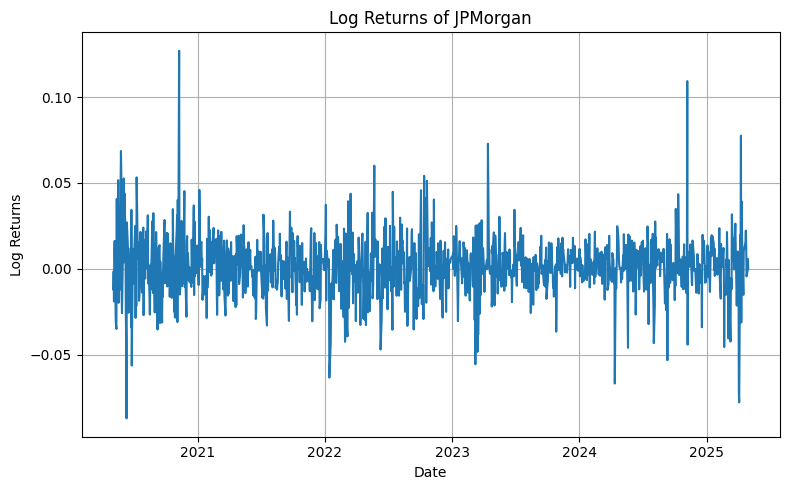

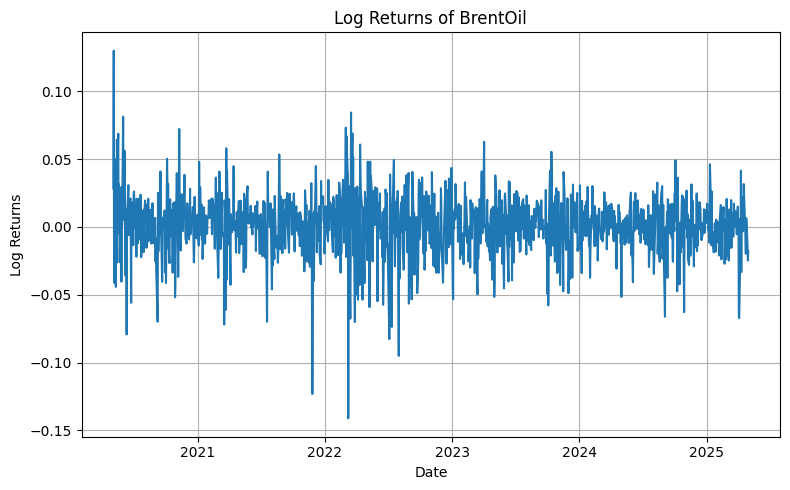

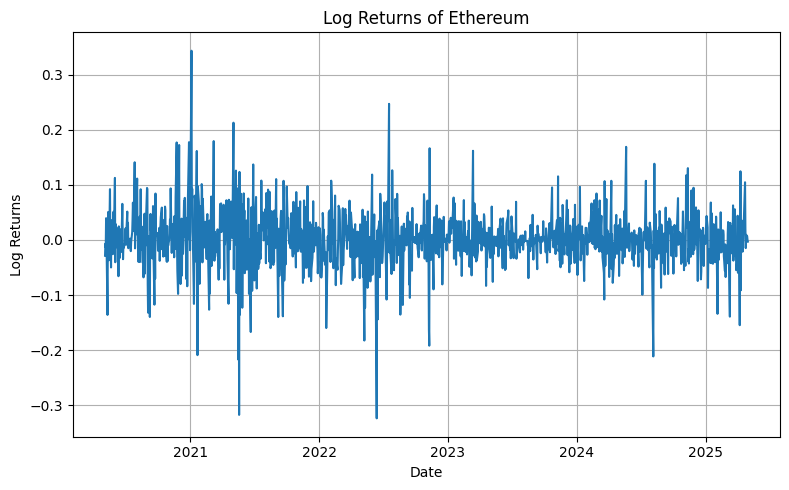

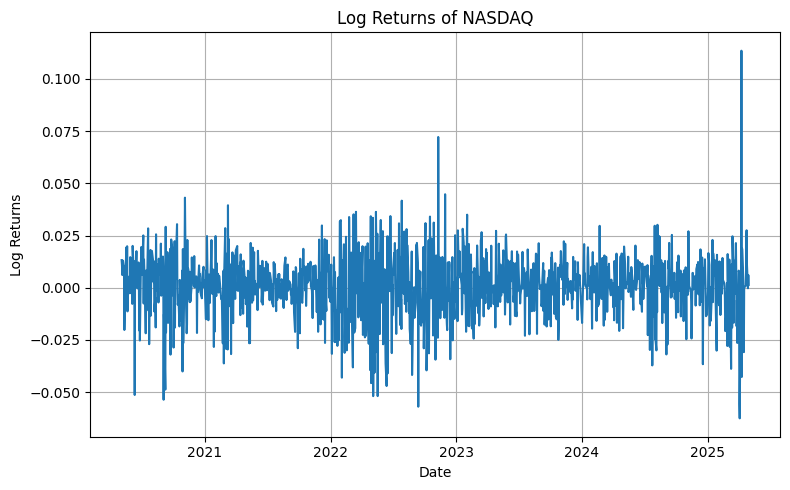

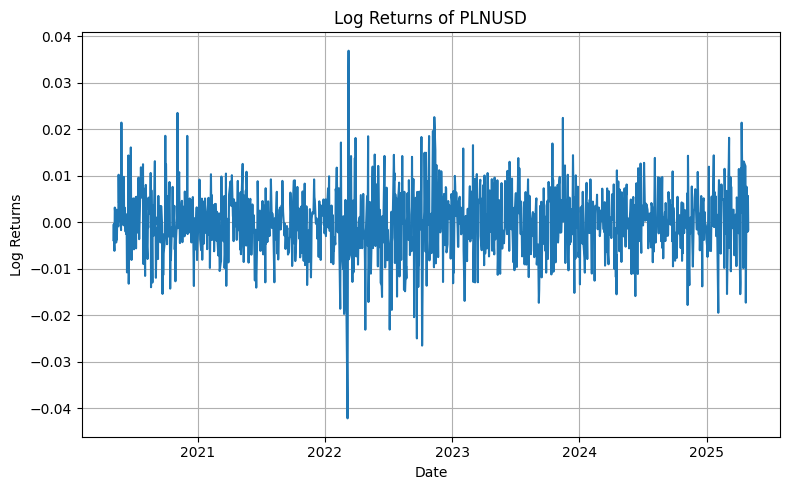

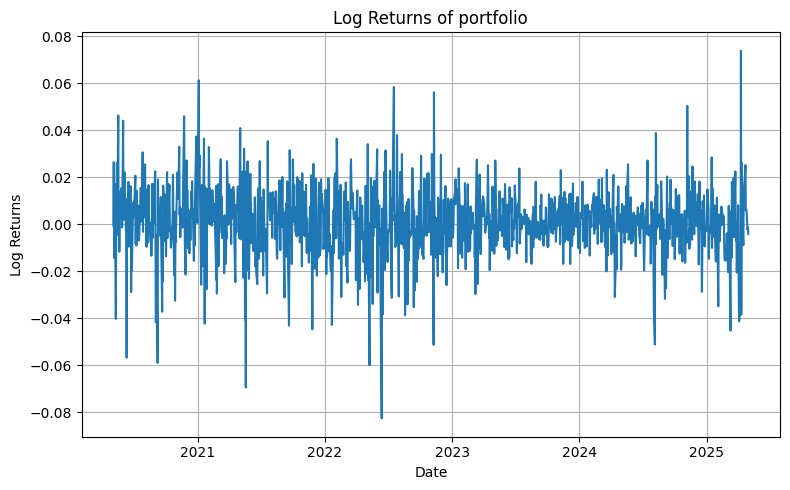

In [72]:
# Generate a plot of each column in the DataFrame
for column in data.columns:
    plt.figure(figsize=(8, 5))
    plt.plot(data.index, data[column], label=column)
    plt.title(f'Log Returns of {column}')
    plt.xlabel('Date')
    plt.ylabel('Log Returns')
    plt.grid()
    plt.tight_layout()
    plt.show()

In [73]:
for column in data.columns:
    print(f"Kurtosis of {column}:", stats.kurtosis(data[column]))

Kurtosis of JPMorgan: 5.8182399979393065
Kurtosis of BrentOil: 3.648798031420064
Kurtosis of Ethereum: 5.981940649369449
Kurtosis of NASDAQ: 3.7070779895463595
Kurtosis of PLNUSD: 1.9738819223832182
Kurtosis of portfolio: 3.422112193542782


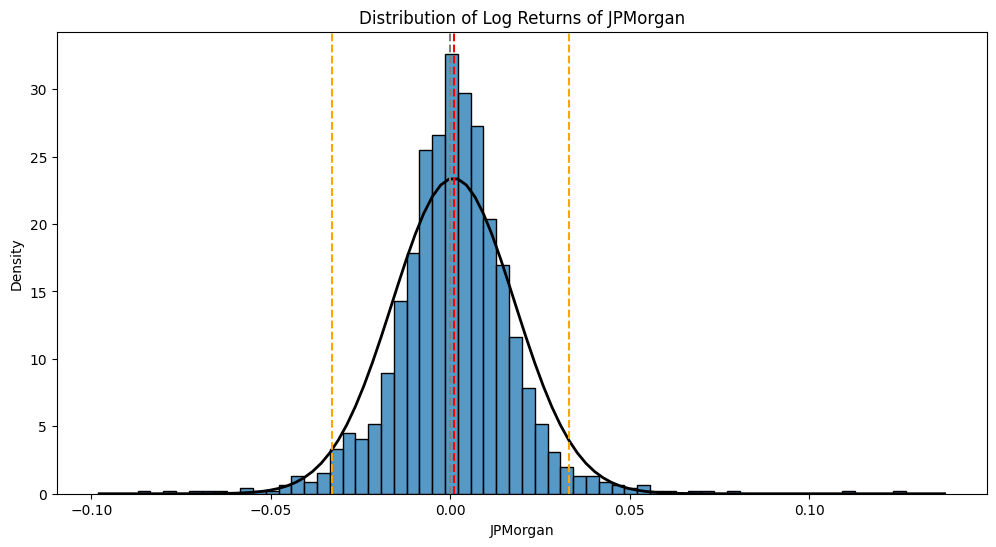

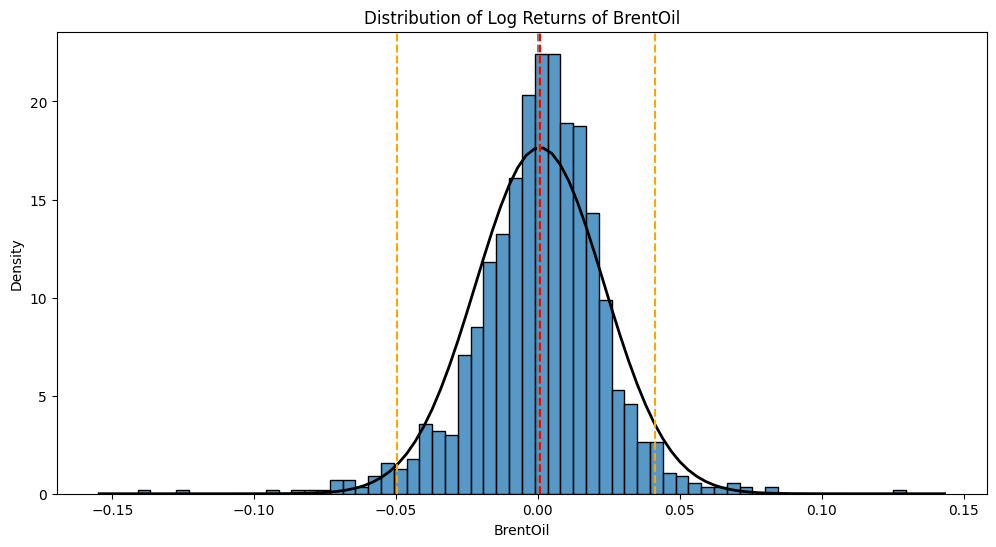

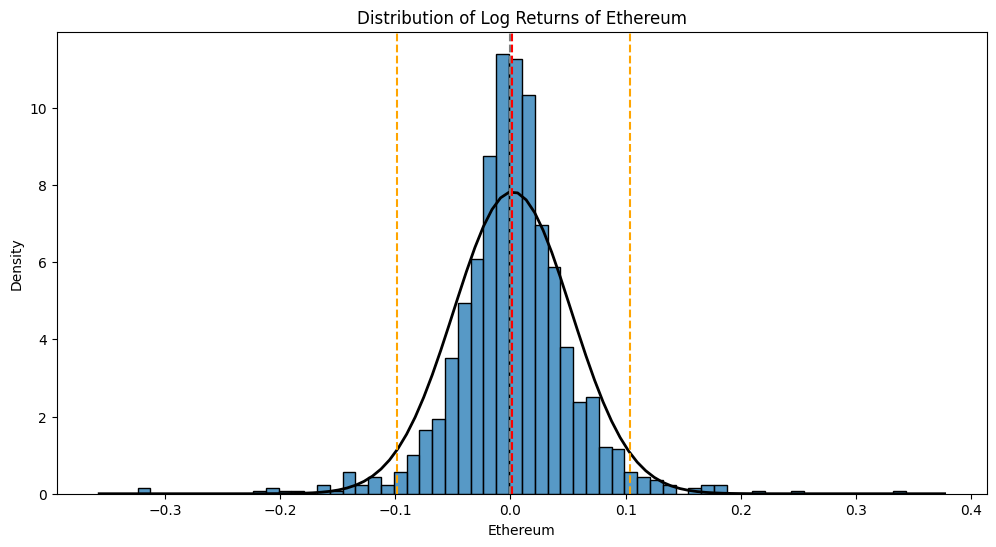

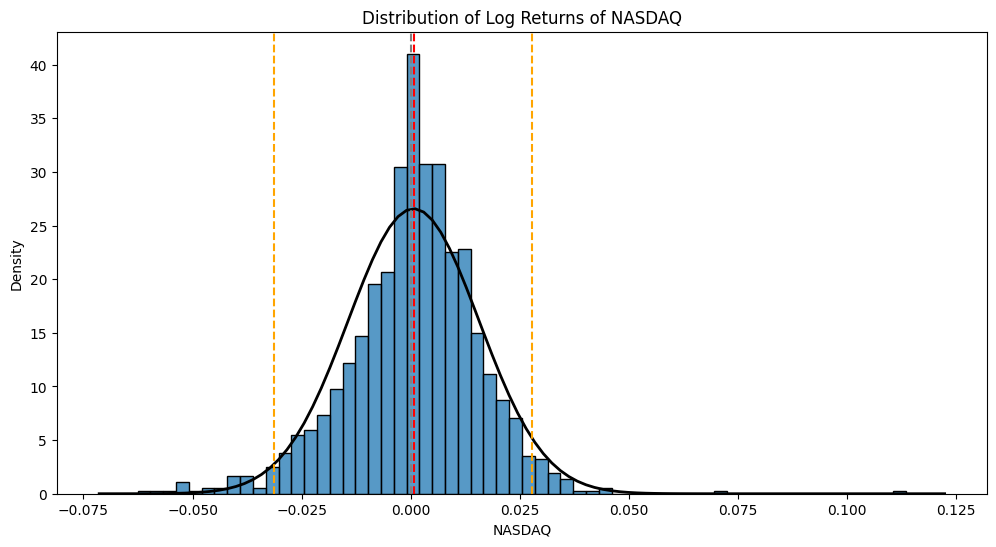

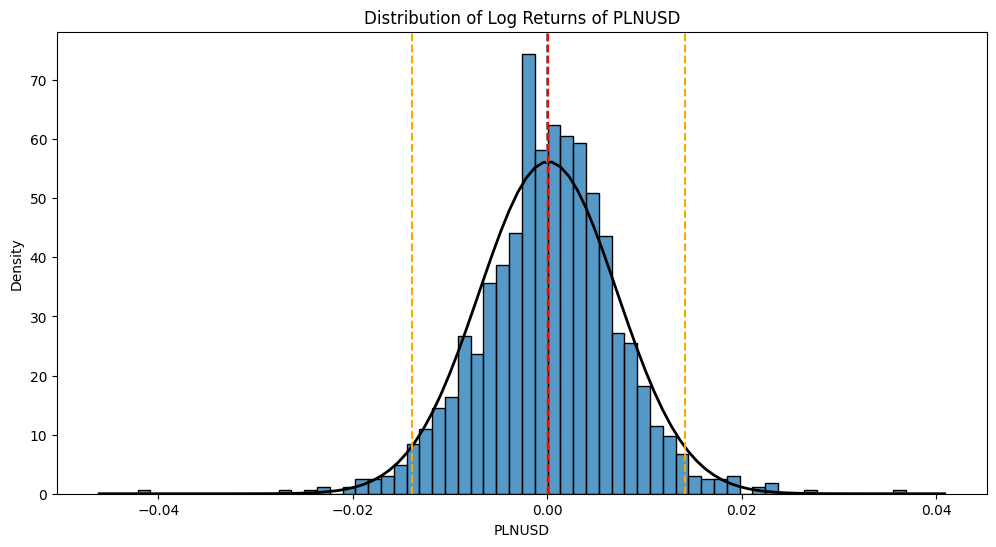

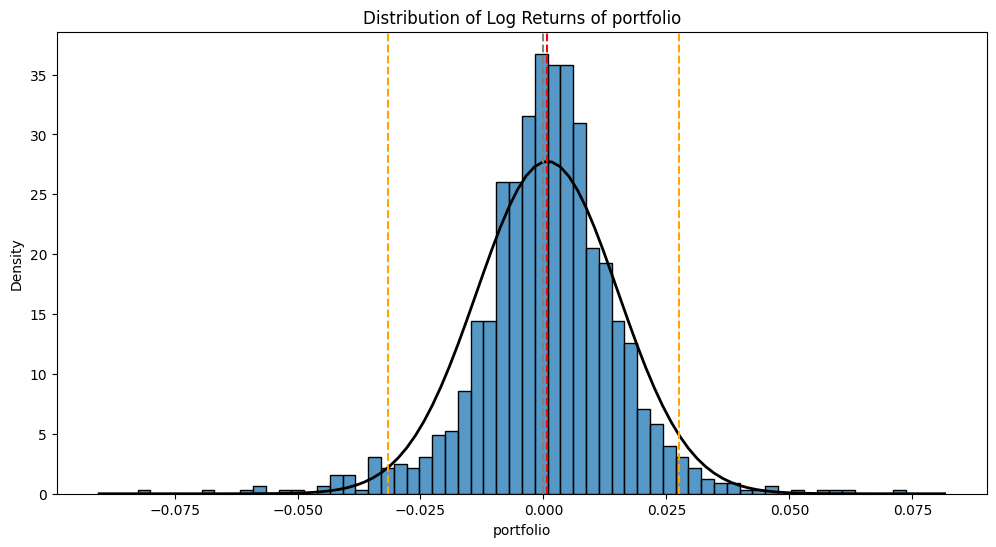

In [74]:
for column in data.columns:
    # Histogram of log returns
    plt.figure(figsize=(12, 6))
    sns.histplot(data[column], stat="density", bins = 60)
    # add normal distribution curve
    mu, std = data[column].mean(), data[column].std()
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.axvline(x=0, linestyle='--', color='gray')
    plt.axvline(x=data[column].mean(), linestyle='--', color='red')
    plt.axvline(x=data[column].quantile(0.025), linestyle='--', color='orange')
    plt.axvline(x=data[column].quantile(0.975), linestyle='--', color='orange')
    plt.title(f'Distribution of Log Returns of {column}')
    plt.show()

In [75]:
for column in data.columns:
    jb_test = stats.jarque_bera(data[column])
    print(f"Jarque-Bera test statistic: {jb_test[0]:.2f}")
    print(f"p-value: {jb_test[1]:.2e}")

Jarque-Bera test statistic: 1792.03
p-value: 0.00e+00
Jarque-Bera test statistic: 738.35
p-value: 4.67e-161
Jarque-Bera test statistic: 1876.74
p-value: 0.00e+00
Jarque-Bera test statistic: 719.48
p-value: 5.84e-157
Jarque-Bera test statistic: 206.57
p-value: 1.39e-45
Jarque-Bera test statistic: 640.93
p-value: 6.68e-140


In [76]:
# H0: No ARCH effects
# H1: ARCH effects are present

for column in data.columns:
    arch_test_results = het_arch(data[column], nlags=5)

    print(f"LM Statistic {column}: {arch_test_results[0]:.3f}")
    print(f"p-value: {arch_test_results[1]:.3f}")
    print(f"F-statistic {column}: {arch_test_results[2]:.3f}")
    print(f"F p-value: {arch_test_results[3]:.3f}")

LM Statistic JPMorgan: 30.995
p-value: 0.000
F-statistic JPMorgan: 6.326
F p-value: 0.000
LM Statistic BrentOil: 76.300
p-value: 0.000
F-statistic BrentOil: 16.175
F p-value: 0.000
LM Statistic Ethereum: 38.395
p-value: 0.000
F-statistic Ethereum: 7.885
F p-value: 0.000
LM Statistic NASDAQ: 89.311
p-value: 0.000
F-statistic NASDAQ: 19.145
F p-value: 0.000
LM Statistic PLNUSD: 107.239
p-value: 0.000
F-statistic PLNUSD: 23.350
F p-value: 0.000
LM Statistic portfolio: 35.780
p-value: 0.000
F-statistic portfolio: 7.332
F p-value: 0.000


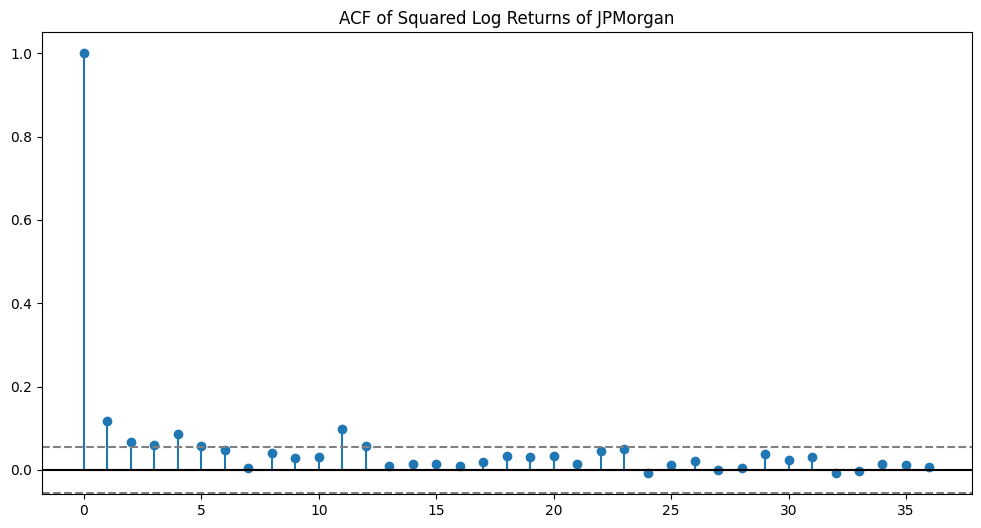

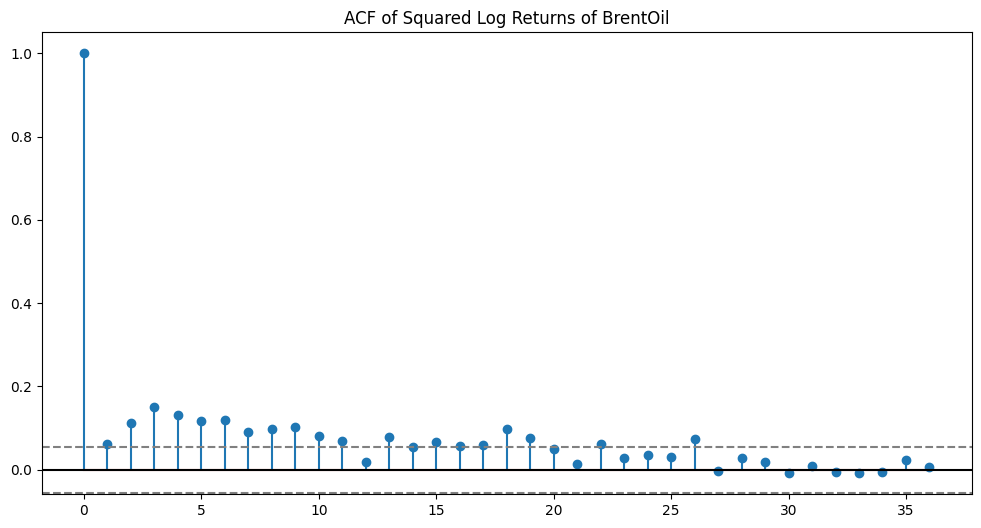

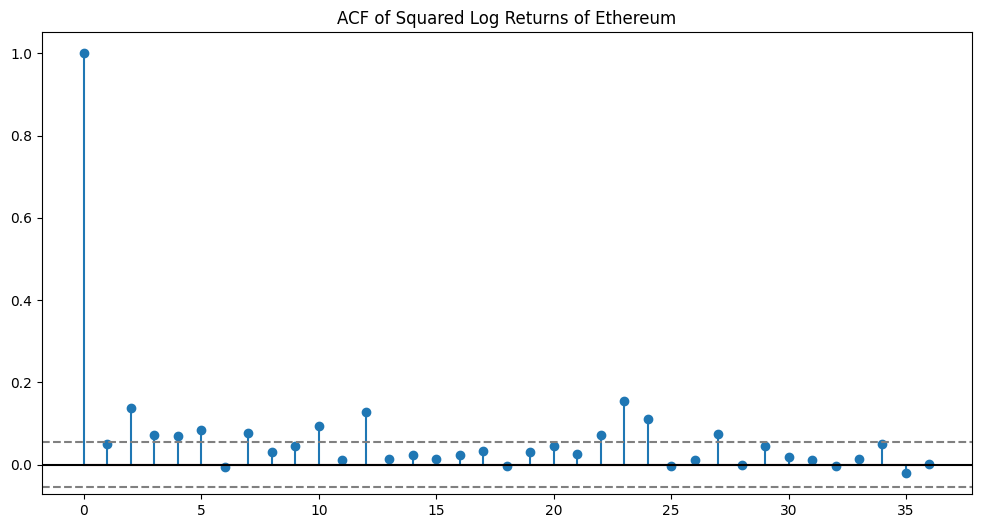

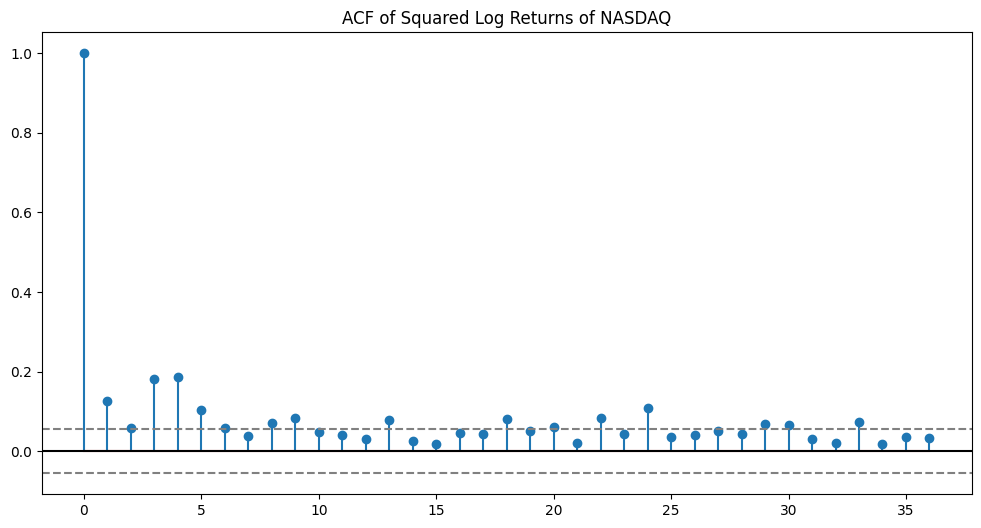

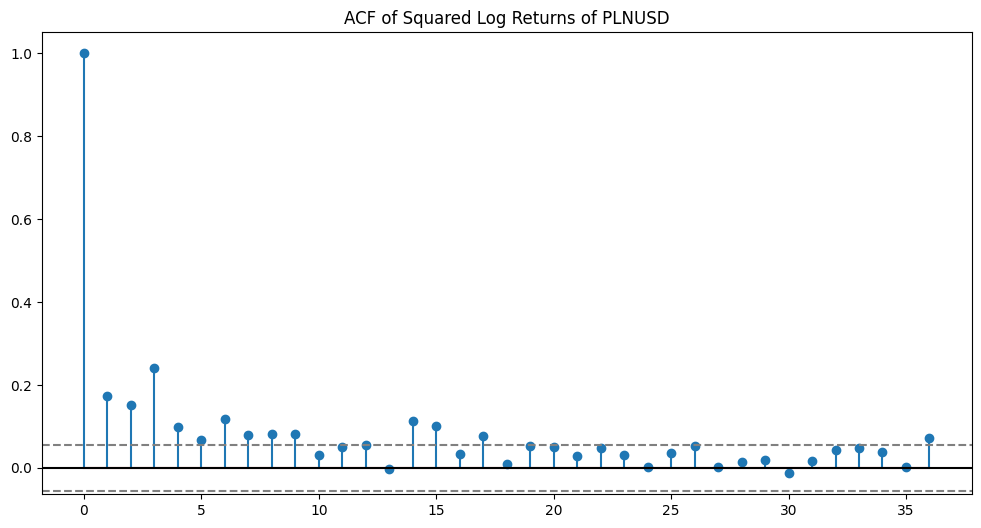

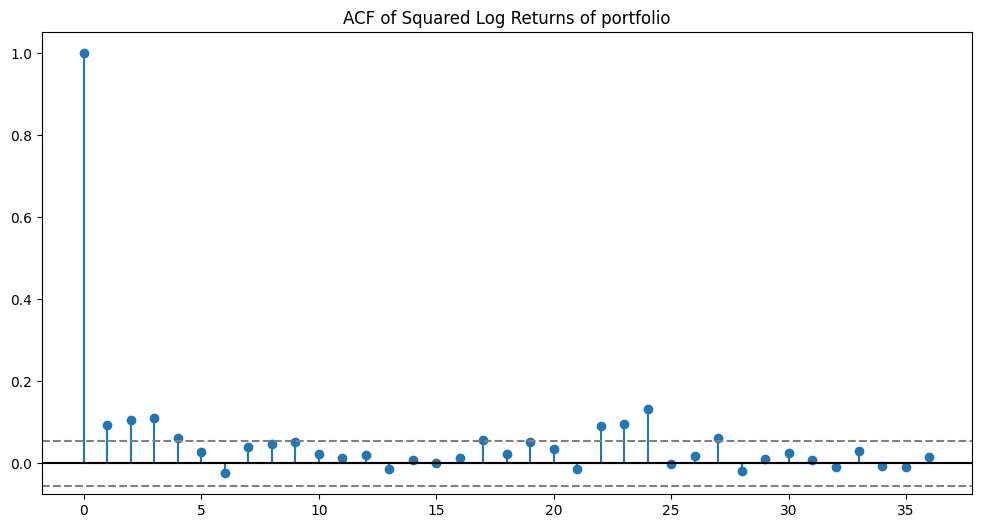

In [77]:
for column in data.columns:
    # Autocorrelation function for squared log returns
    acf_squared = acf(data[column]**2, nlags=36)
    plt.figure(figsize=(12, 6))
    plt.stem(range(len(acf_squared)), acf_squared)
    plt.axhline(y=0, linestyle='-', color='black')
    plt.axhline(y=-1.96/np.sqrt(len(data[column])), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data[column])), linestyle='--', color='gray')
    plt.title(f'ACF of Squared Log Returns of {column}')
    plt.show()

In [78]:
data_train = data[data.index < '2024-05-01'].copy()
data_test = data[data.index >= '2024-05-01'].copy()
data_train

,JPMorgan,BrentOil,Ethereum,NASDAQ,PLNUSD,portfolio
Date,,,,,,
2020-05-04,-0.011975,0.028339,-0.028625,0.013210,-0.003828,-0.000576
2020-05-05,-0.001521,0.129802,-0.006746,0.010865,-0.000415,0.026397
2020-05-06,-0.018983,-0.041199,-0.013235,0.006055,-0.004130,-0.014298
2020-05-07,0.010359,-0.008787,0.039557,0.012940,-0.006126,0.009589
2020-05-08,0.016204,0.049986,0.003302,0.012932,0.003177,0.017120
...,...,...,...,...,...,...
2024-04-24,0.004880,-0.004534,-0.025193,0.003162,0.006269,-0.003083
2024-04-25,0.001501,0.011185,0.005306,-0.005510,-0.006213,0.001254
2024-04-26,0.000620,0.005490,-0.008381,0.016377,0.007059,0.004233


In [79]:
model_garch11 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=1, q=1)
results_garch11 = model_garch11.fit(disp='off')
print(results_garch11.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1748.70
Distribution:                  Normal   AIC:                           3505.40
Method:            Maximum Likelihood   BIC:                           3525.05
                                        No. Observations:                 1005
Date:                Fri, May 30 2025   Df Residuals:                     1004
Time:                        12:14:06   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1017  4.018e-02      2.531  1.139e-02 [2.293e-0

In [80]:
model_garch12 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=1, q=2)
results_garch12 = model_garch12.fit(disp='off')
print(results_garch12.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1748.69
Distribution:                  Normal   AIC:                           3507.37
Method:            Maximum Likelihood   BIC:                           3531.94
                                        No. Observations:                 1005
Date:                Fri, May 30 2025   Df Residuals:                     1004
Time:                        12:14:06   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1018  4.026e-02      2.530  1.141e-02 [2.294e-0

In [81]:
model_garch21 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=2, q=1)
results_garch21 = model_garch21.fit(disp='off')
print(results_garch21.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1748.70
Distribution:                  Normal   AIC:                           3507.40
Method:            Maximum Likelihood   BIC:                           3531.96
                                        No. Observations:                 1005
Date:                Fri, May 30 2025   Df Residuals:                     1004
Time:                        12:14:06   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1017  4.118e-02      2.469  1.354e-02 [2.097e-0

In [82]:
model_garch22 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=2, q=2)
results_garch22 = model_garch22.fit(disp='off')
print(results_garch22.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1748.20
Distribution:                  Normal   AIC:                           3508.39
Method:            Maximum Likelihood   BIC:                           3537.87
                                        No. Observations:                 1005
Date:                Fri, May 30 2025   Df Residuals:                     1004
Time:                        12:14:06   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1013  4.003e-02      2.532  1.135e-02 [2.288e-0

In [83]:
model_garch10 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=1, q=0)
results_garch10 = model_garch10.fit(disp='off')
print(results_garch10.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1798.09
Distribution:                  Normal   AIC:                           3602.18
Method:            Maximum Likelihood   BIC:                           3616.91
                                        No. Observations:                 1005
Date:                Fri, May 30 2025   Df Residuals:                     1004
Time:                        12:14:06   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1141  4.554e-02      2.506  1.221e-02 [2.487e-0

In [84]:
model_garch20 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=2, q=0)
results_garch20 = model_garch20.fit(disp='off')
print(results_garch20.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1782.18
Distribution:                  Normal   AIC:                           3572.37
Method:            Maximum Likelihood   BIC:                           3592.02
                                        No. Observations:                 1005
Date:                Fri, May 30 2025   Df Residuals:                     1004
Time:                        12:14:06   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1376  4.309e-02      3.194  1.405e-03 [5.316e-0

In [85]:
model_garch31 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=3, q=1)
results_garch31 = model_garch31.fit(disp='off')
print(results_garch31.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1748.70
Distribution:                  Normal   AIC:                           3509.40
Method:            Maximum Likelihood   BIC:                           3538.88
                                        No. Observations:                 1005
Date:                Fri, May 30 2025   Df Residuals:                     1004
Time:                        12:14:06   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1017  4.210e-02      2.415  1.573e-02 [1.916e-0

In [86]:
model_garch32 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=3, q=2)
results_garch32 = model_garch32.fit(disp='off')
print(results_garch32.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1748.20
Distribution:                  Normal   AIC:                           3510.39
Method:            Maximum Likelihood   BIC:                           3544.78
                                        No. Observations:                 1005
Date:                Fri, May 30 2025   Df Residuals:                     1004
Time:                        12:14:06   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1013  4.104e-02      2.469  1.355e-02 [2.089e-0

In [87]:
model_garch13 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=1, q=3)
results_garch13 = model_garch13.fit(disp='off')
print(results_garch13.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1748.30
Distribution:                  Normal   AIC:                           3508.59
Method:            Maximum Likelihood   BIC:                           3538.07
                                        No. Observations:                 1005
Date:                Fri, May 30 2025   Df Residuals:                     1004
Time:                        12:14:06   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1037  4.100e-02      2.529  1.142e-02 [2.335e-0

In [88]:
model_garch23 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=2, q=3)
results_garch23 = model_garch23.fit(disp='off')
print(results_garch23.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1746.90
Distribution:                  Normal   AIC:                           3507.80
Method:            Maximum Likelihood   BIC:                           3542.19
                                        No. Observations:                 1005
Date:                Fri, May 30 2025   Df Residuals:                     1004
Time:                        12:14:06   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1050  3.965e-02      2.649  8.072e-03 [2.732e-0

In [89]:
model_garch33 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=3, q=3)
results_garch33 = model_garch33.fit(disp='off')
print(results_garch33.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1746.90
Distribution:                  Normal   AIC:                           3509.80
Method:            Maximum Likelihood   BIC:                           3549.10
                                        No. Observations:                 1005
Date:                Fri, May 30 2025   Df Residuals:                     1004
Time:                        12:14:06   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1050  3.982e-02      2.638  8.333e-03 [2.701e-0

In [90]:
models = {
    'GARCH(1,1)': results_garch11,
    'GARCH(1,2)': results_garch12,
    'GARCH(2,1)': results_garch21,
    'GARCH(2,2)': results_garch22,
    'GARCH(1,0)': results_garch10,
    'GARCH(2,0)': results_garch20,
    'GARCH(3,1)': results_garch31,
    'GARCH(3,2)': results_garch32,
    'GARCH(1,3)': results_garch13,
    'GARCH(2,3)': results_garch23,
    'GARCH(3,3)': results_garch33
}

In [91]:
def compare_arch_models(model_results_dict):
    if not model_results_dict:
        print("No model results provided.")
        return pd.DataFrame()

    ic_data = []
    for name, model in model_results_dict.items():
        if hasattr(model, 'aic') and hasattr(model, 'bic'):
            ic_data.append({
                'Model': name,
                'lb_5' : sm.stats.acorr_ljungbox(model.std_resid, lags=[5], return_df=True)['lb_pvalue'].iloc[0],
                'lb_10' : sm.stats.acorr_ljungbox(model.std_resid, lags=[10], return_df=True)['lb_pvalue'].iloc[0],
                'lb_15' : sm.stats.acorr_ljungbox(model.std_resid, lags=[15], return_df=True)['lb_pvalue'].iloc[0],
                'lb_20' : sm.stats.acorr_ljungbox(model.std_resid, lags=[20], return_df=True)['lb_pvalue'].iloc[0],
                'lb_sq_5' : sm.stats.acorr_ljungbox(model.std_resid**2, lags=[5], return_df=True)['lb_pvalue'].iloc[0],
                'lb_sq_10' : sm.stats.acorr_ljungbox(model.std_resid**2, lags=[10], return_df=True)['lb_pvalue'].iloc[0],
                'lb_sq_15' : sm.stats.acorr_ljungbox(model.std_resid**2, lags=[15], return_df=True)['lb_pvalue'].iloc[0],
                'lb_sq_20' : sm.stats.acorr_ljungbox(model.std_resid**2, lags=[20], return_df=True)['lb_pvalue'].iloc[0],
                'het_arch_LM': het_arch(model.std_resid, nlags=5)[1],
                'het_arch_F': het_arch(model.std_resid, nlags=5)[3],
                'AIC': model.aic,
                'BIC': model.bic,
                'LogLikelihood': model.loglikelihood,
                'Num Params': len(model.params)
            })
        else:
            print(f"Warning: Model {name} does not have standard IC attributes.")
            ic_data.append({
                'Model': name,
                'AIC': np.nan,
                'BIC': np.nan,
                'LogLikelihood': np.nan,
                'Num Params': np.nan
            })
            
    ic_df = pd.DataFrame(ic_data)
    if not ic_df.empty:
      ic_df = ic_df.set_index('Model')
    return ic_df

In [92]:
compare_arch_models(models)

,lb_5,lb_10,lb_15,lb_20,lb_sq_5,lb_sq_10,lb_sq_15,lb_sq_20,het_arch_LM,het_arch_F,AIC,BIC,LogLikelihood,Num Params
Model,,,,,,,,,,,,,,
"GARCH(1,1)",0.599812,0.088898,0.036634,0.074877,0.097519,0.130445,0.150450,0.295421,0.098467,0.098418,3505.399445,3525.050416,-1748.699722,4
"GARCH(1,2)",0.599294,0.088544,0.036410,0.074580,0.098570,0.131256,0.151910,0.297350,0.098794,0.098746,3507.373544,3531.937258,-1748.686772,5
"GARCH(2,1)",0.599814,0.088900,0.036635,0.074879,0.097523,0.130442,0.150442,0.295406,0.098469,0.098420,3507.399445,3531.963159,-1748.699722,5
"GARCH(2,2)",0.604698,0.093574,0.040417,0.080560,0.117011,0.139771,0.147703,0.285748,0.128063,0.128149,3508.390530,3537.866987,-1748.195265,6
"GARCH(1,0)",0.344297,0.015108,0.002933,0.003899,0.000849,0.000091,0.000838,0.000349,0.001637,0.001566,3602.176001,3616.914230,-1798.088001,3
"GARCH(2,0)",0.404555,0.032646,0.014836,0.021278,0.076866,0.000804,0.007524,0.000117,0.075239,0.075095,3572.367627,3592.018598,-1782.183813,4
"GARCH(3,1)",0.599817,0.088901,0.036635,0.074880,0.097537,0.130453,0.150448,0.295410,0.098482,0.098433,3509.399446,3538.875902,-1748.699723,6
"GARCH(3,2)",0.604695,0.093576,0.040418,0.080561,0.117007,0.139764,0.147696,0.285738,0.128060,0.128146,3510.390530,3544.779730,-1748.195265,7
"GARCH(1,3)",0.598192,0.087377,0.036032,0.074723,0.119830,0.148072,0.170072,0.320459,0.115327,0.115353,3508.592824,3538.069280,-1748.296412,6


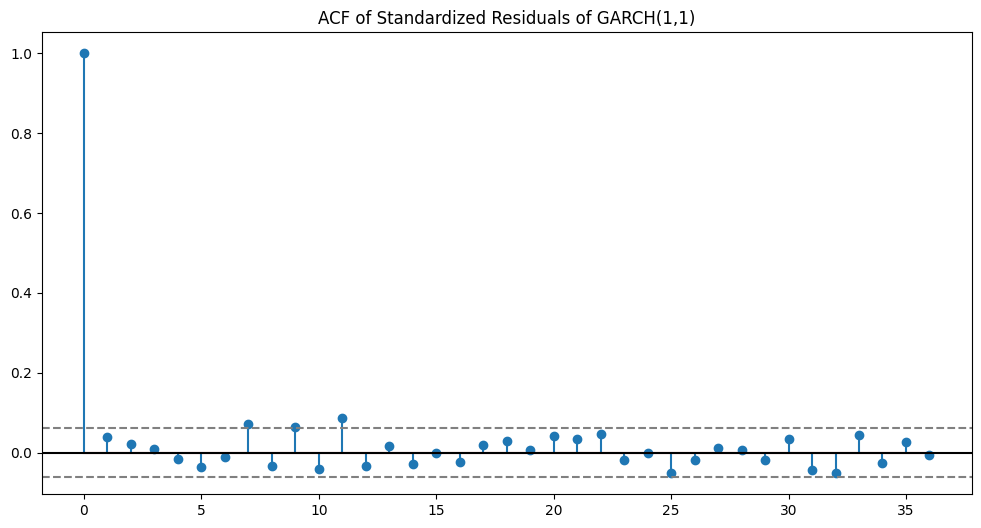

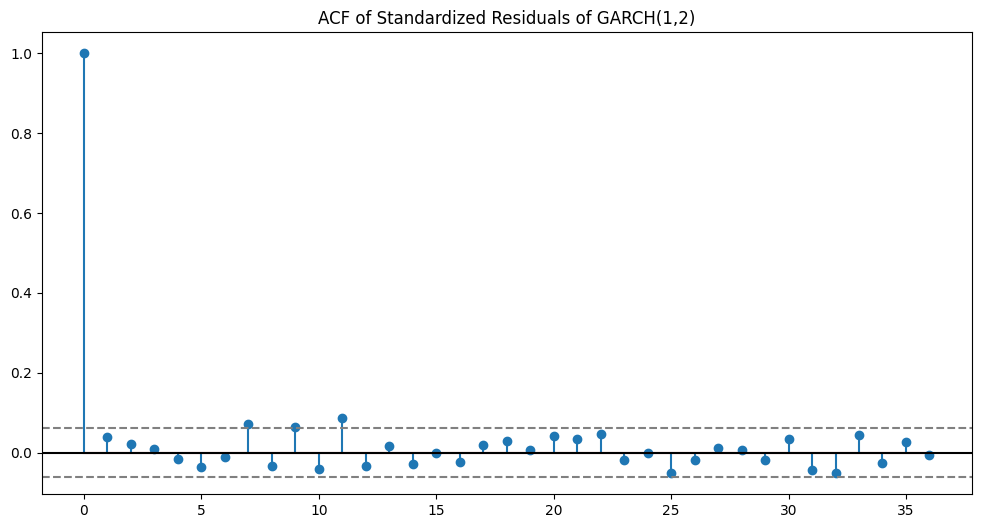

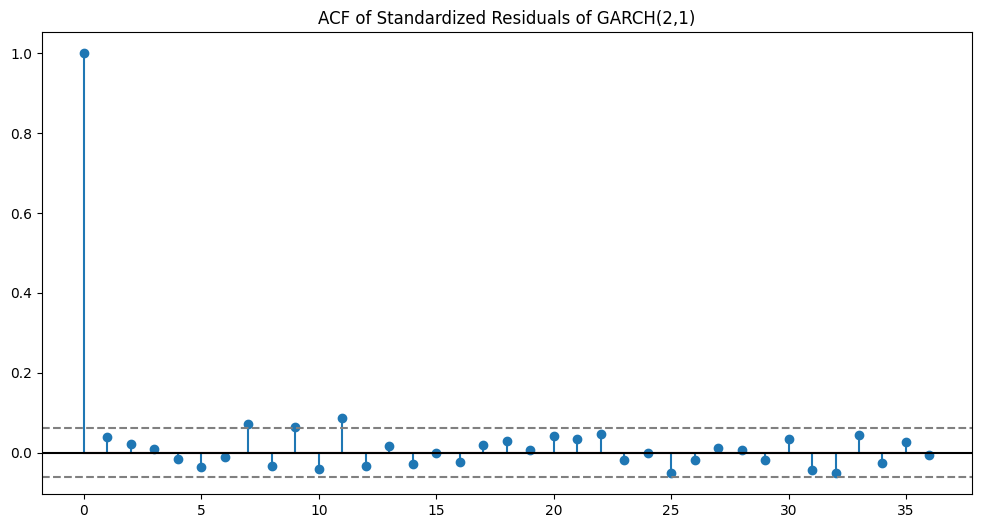

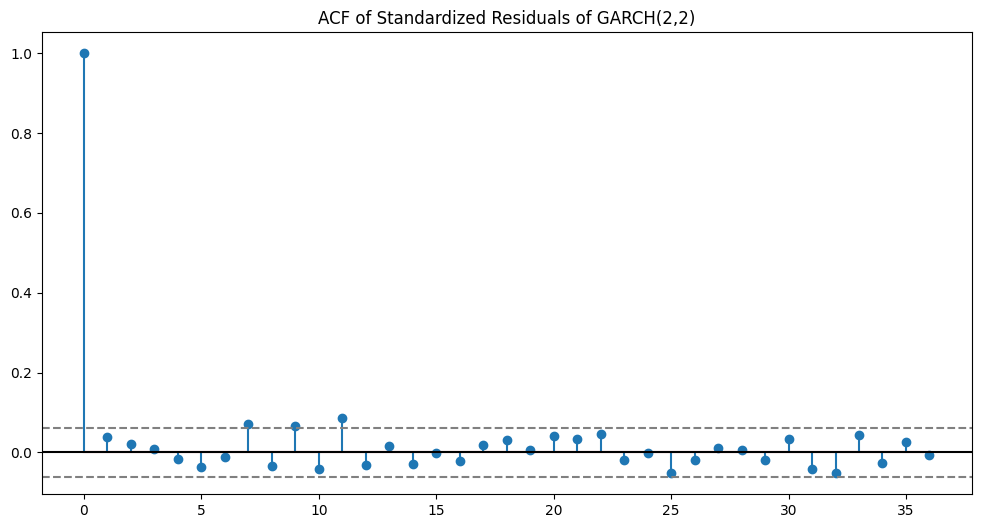

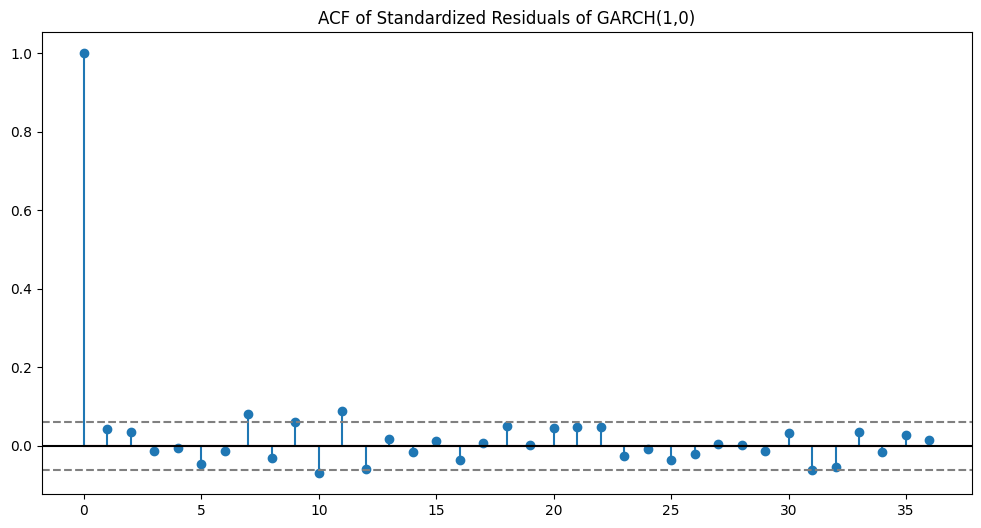

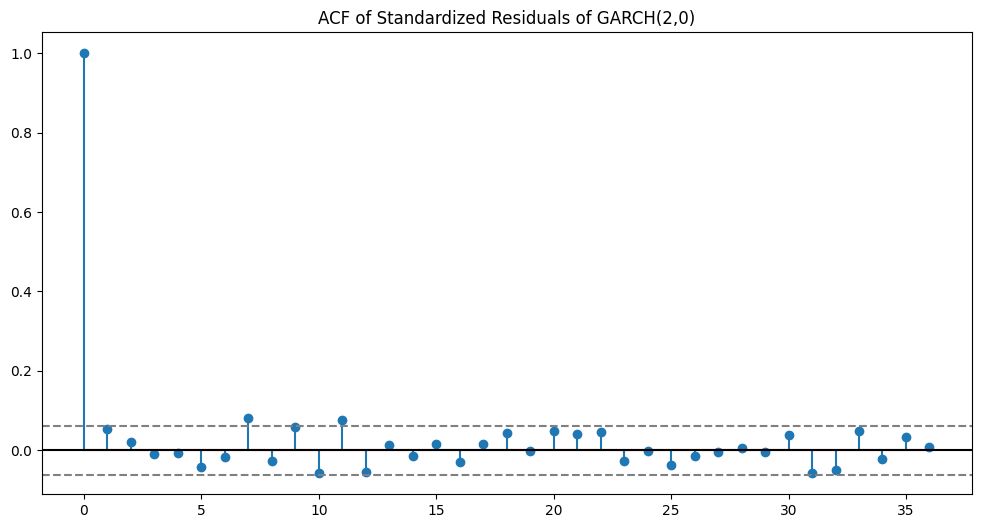

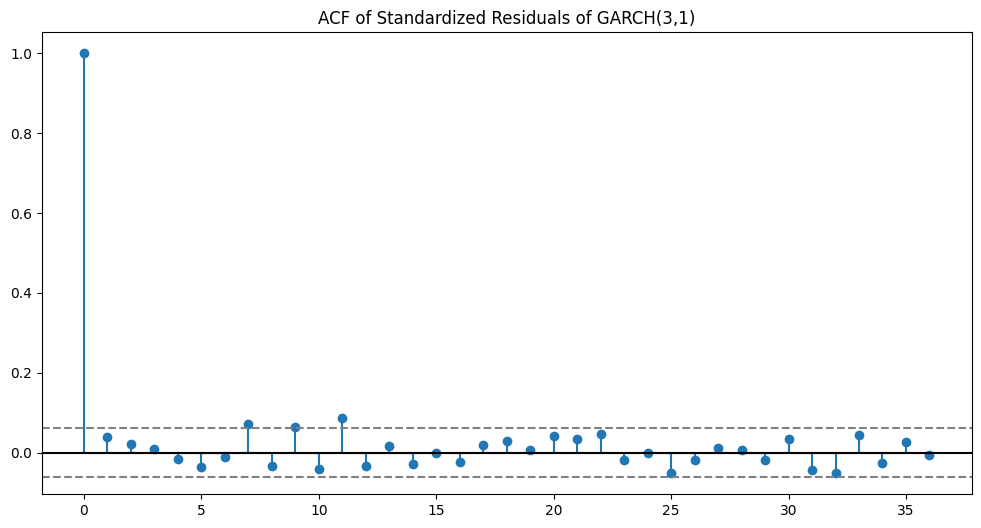

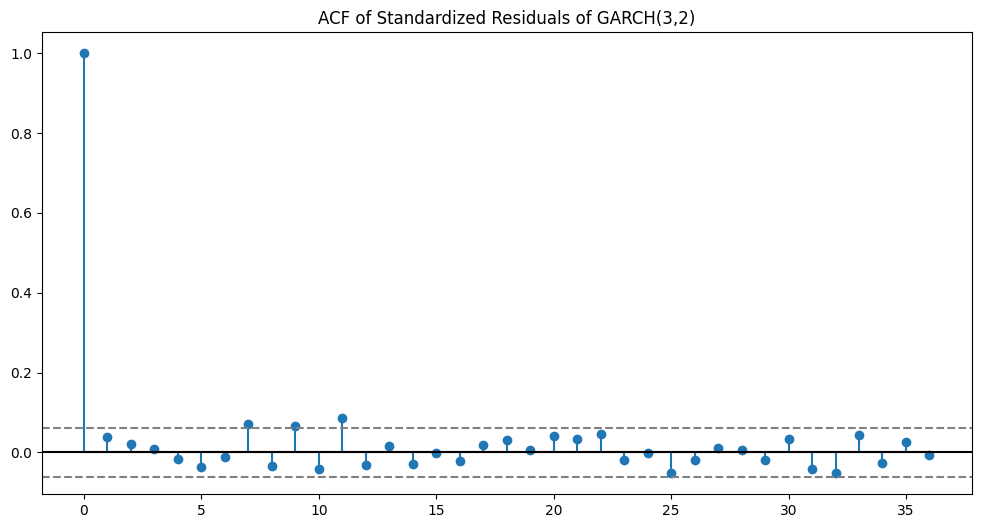

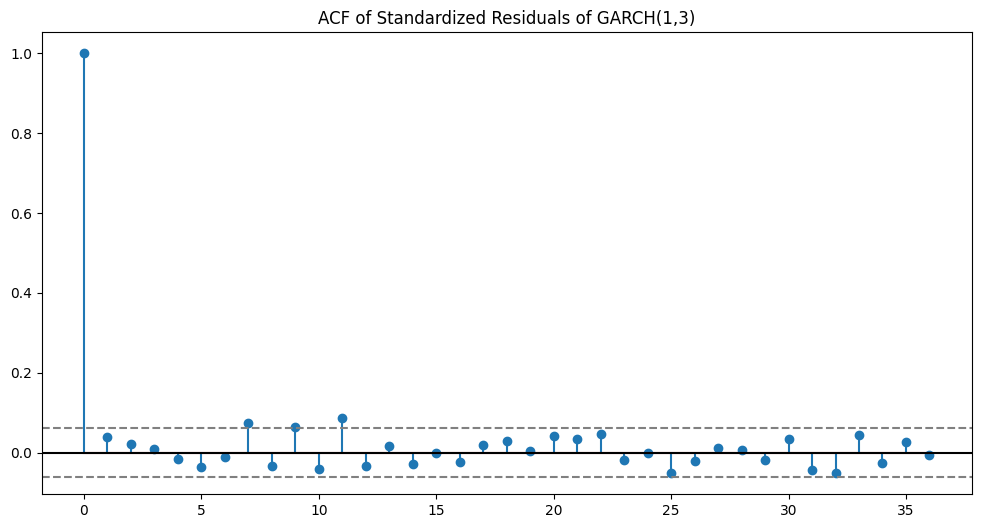

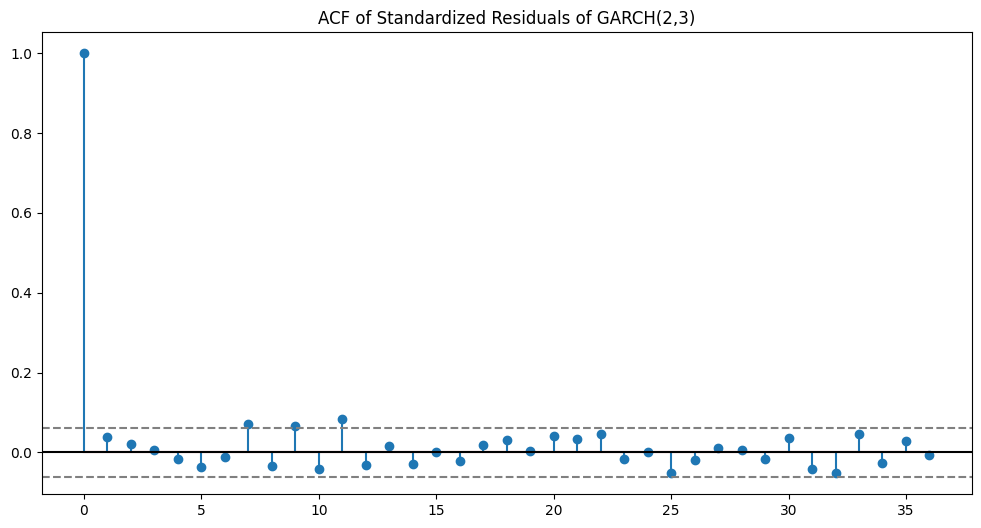

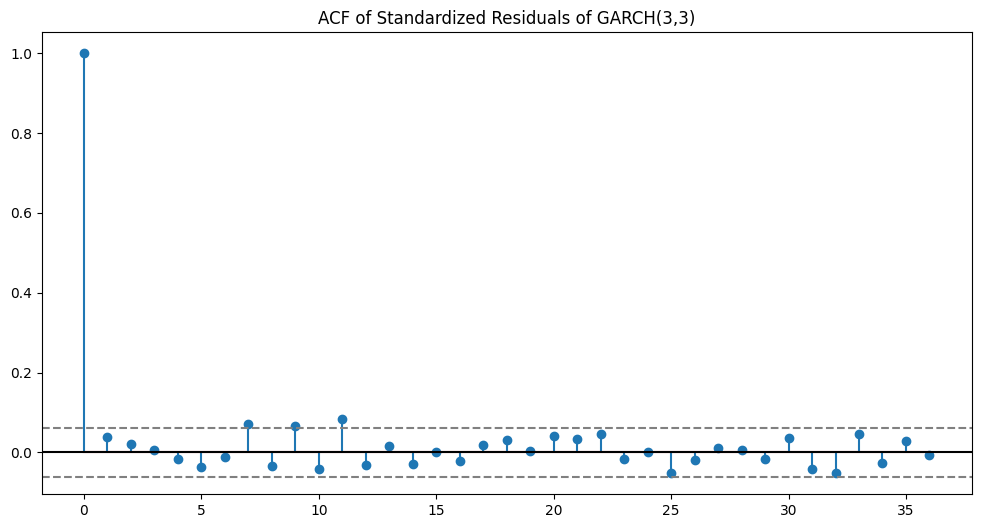

In [93]:
for name, model in models.items():
    acf(model.std_resid, nlags=36)
    plt.figure(figsize=(12, 6))
    plt.stem(range(len(acf(model.std_resid, nlags=36))), acf(model.std_resid, nlags=36))
    plt.axhline(y=0, linestyle='-', color='black')
    plt.axhline(y=-1.96/np.sqrt(len(model.std_resid)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(model.std_resid)), linestyle='--', color='gray')
    plt.title(f'ACF of Standardized Residuals of {name}')
    plt.show()

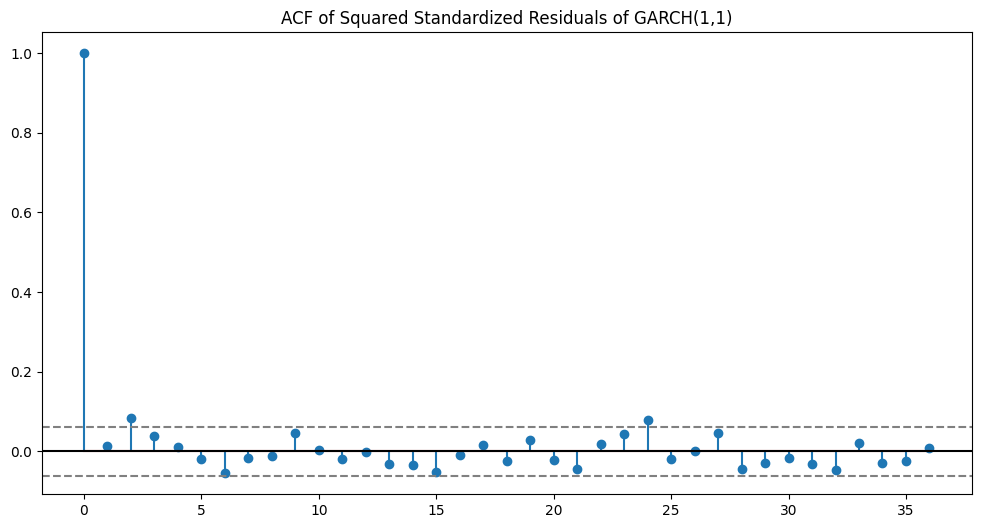

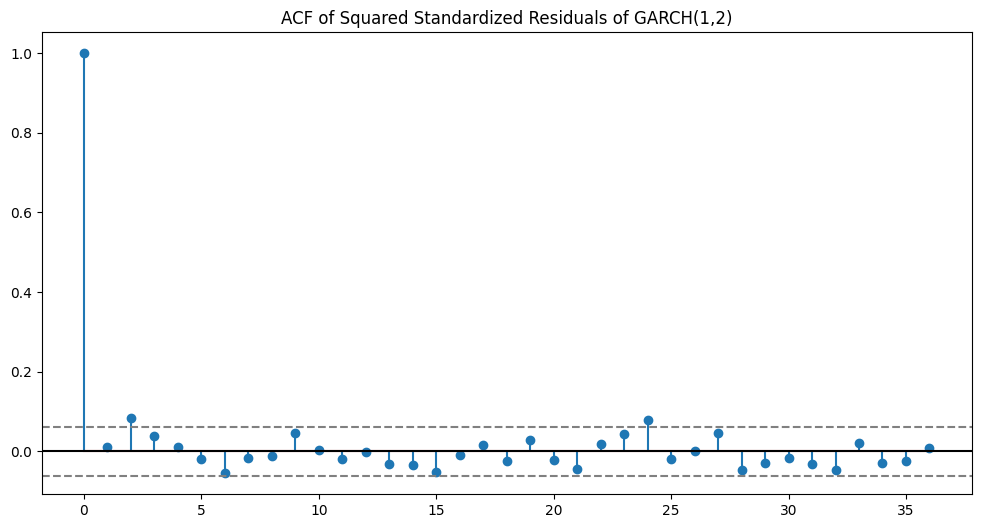

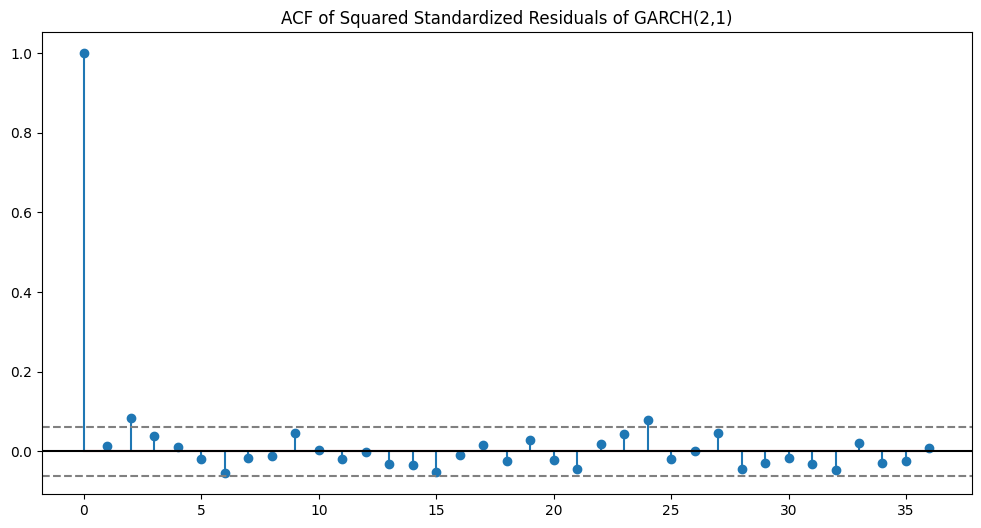

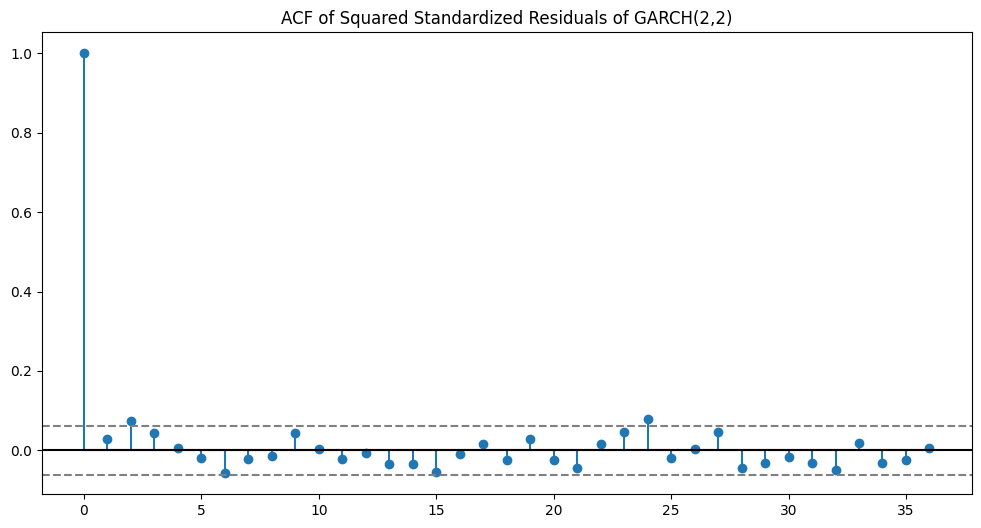

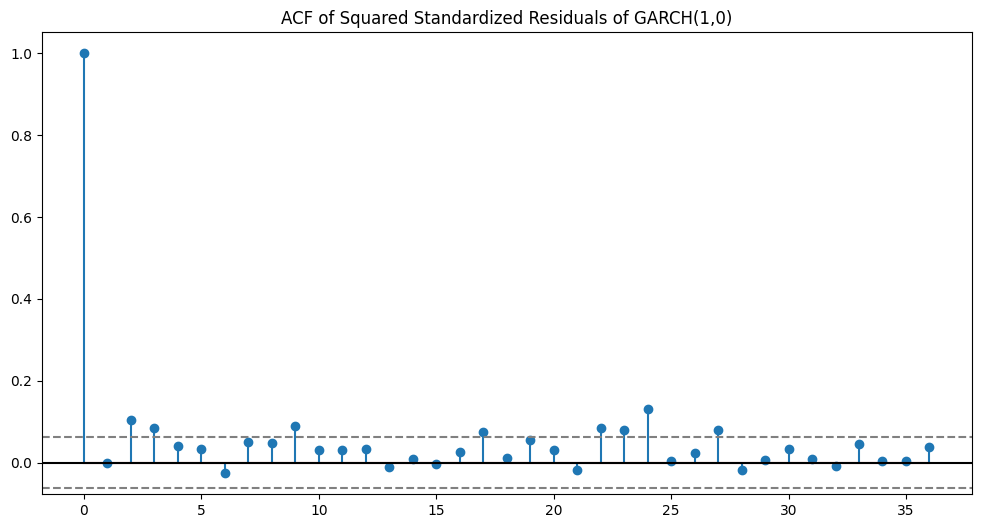

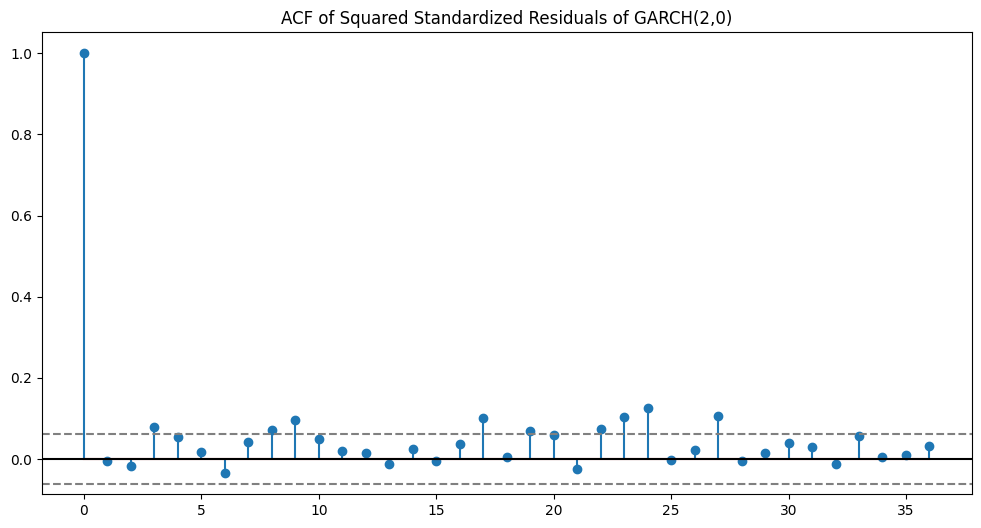

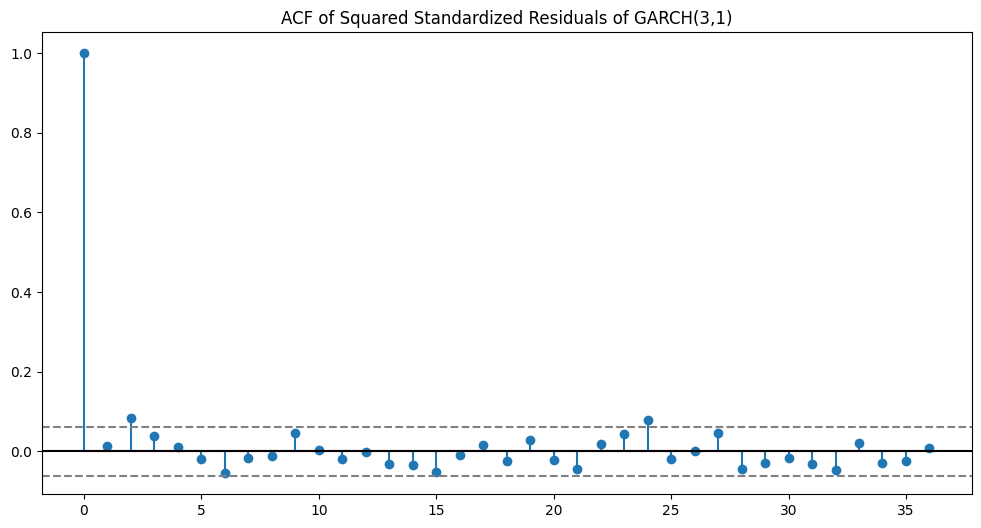

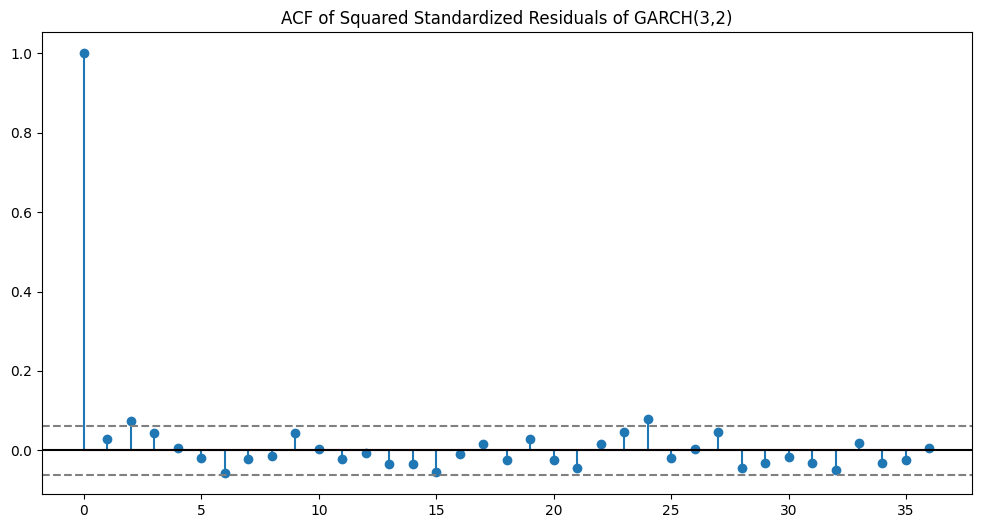

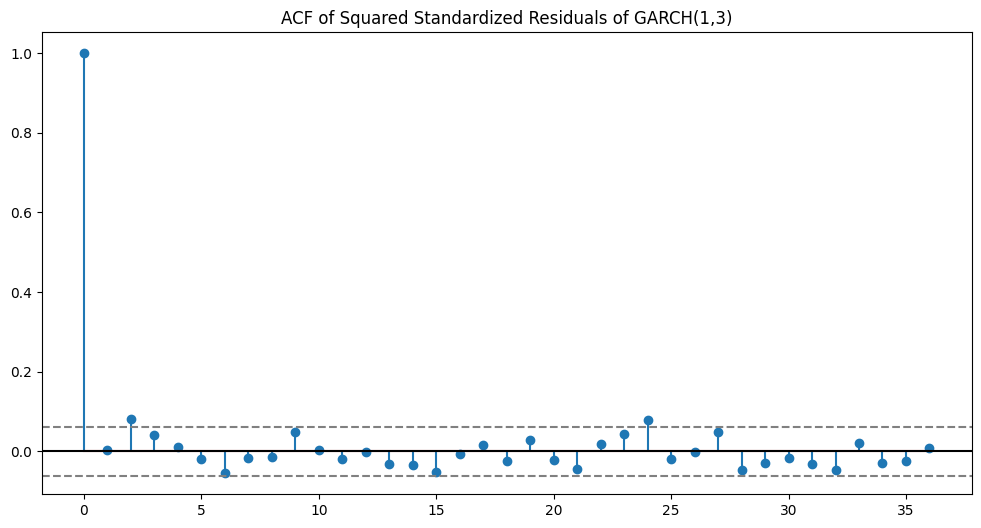

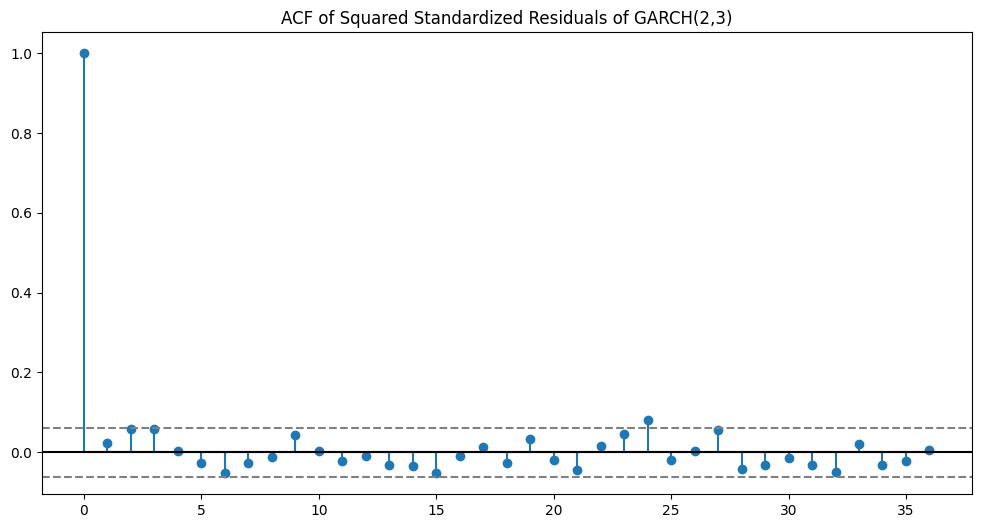

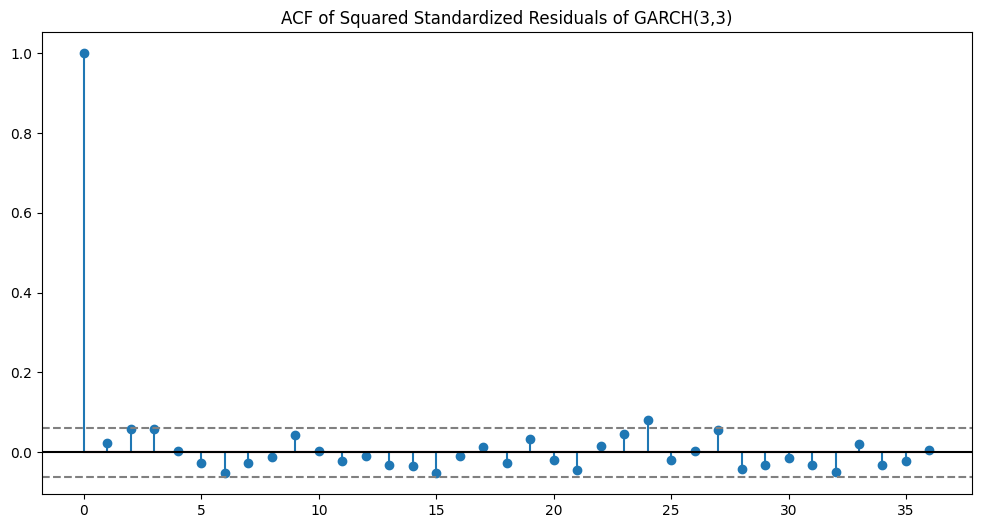

In [94]:
for name, model in models.items():
    acf(model.std_resid**2, nlags=36)
    plt.figure(figsize=(12, 6))
    plt.stem(range(len(acf(model.std_resid**2, nlags=36))), acf(model.std_resid**2, nlags=36))
    plt.axhline(y=0, linestyle='-', color='black')
    plt.axhline(y=-1.96/np.sqrt(len(model.std_resid**2)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(model.std_resid**2)), linestyle='--', color='gray')
    plt.title(f'ACF of Squared Standardized Residuals of {name}')
    plt.show()


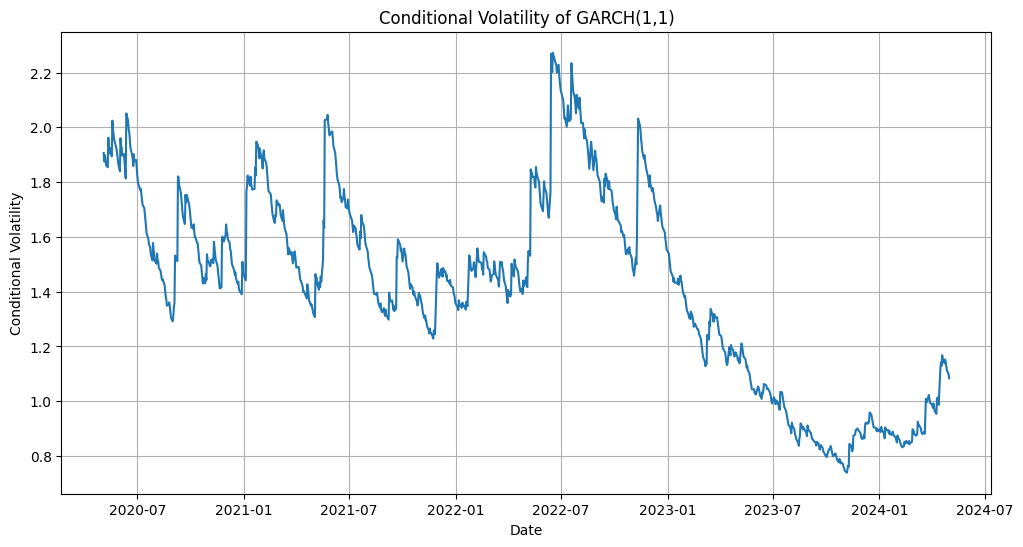

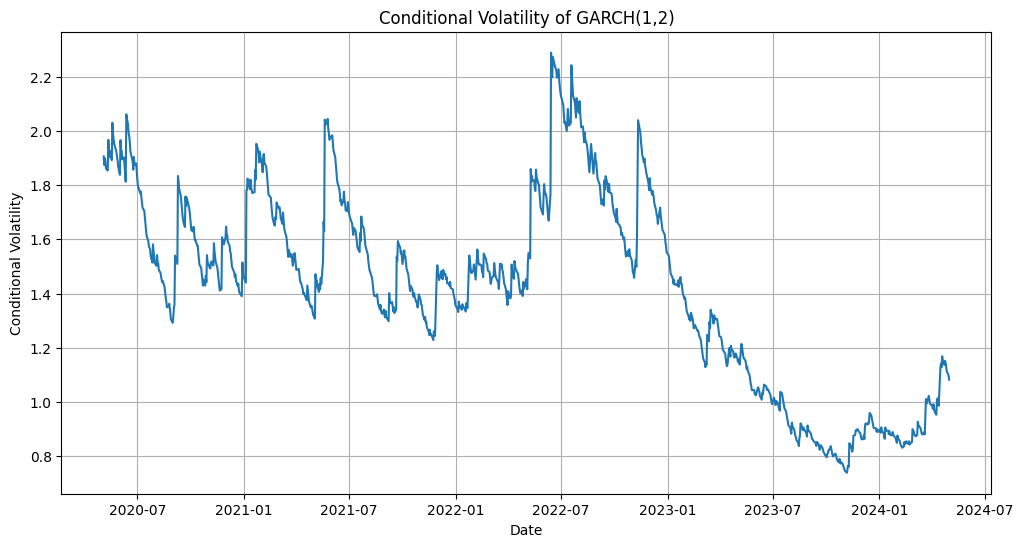

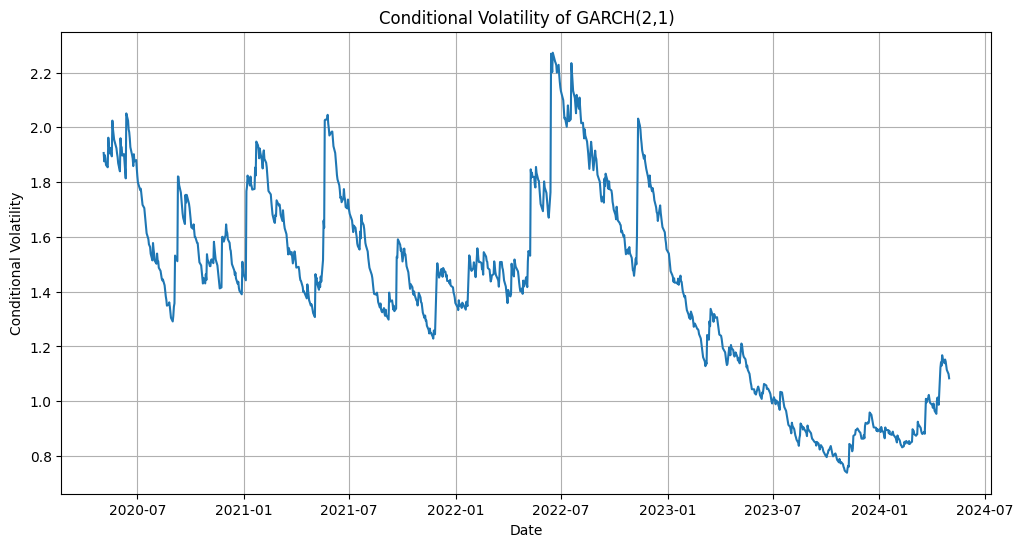

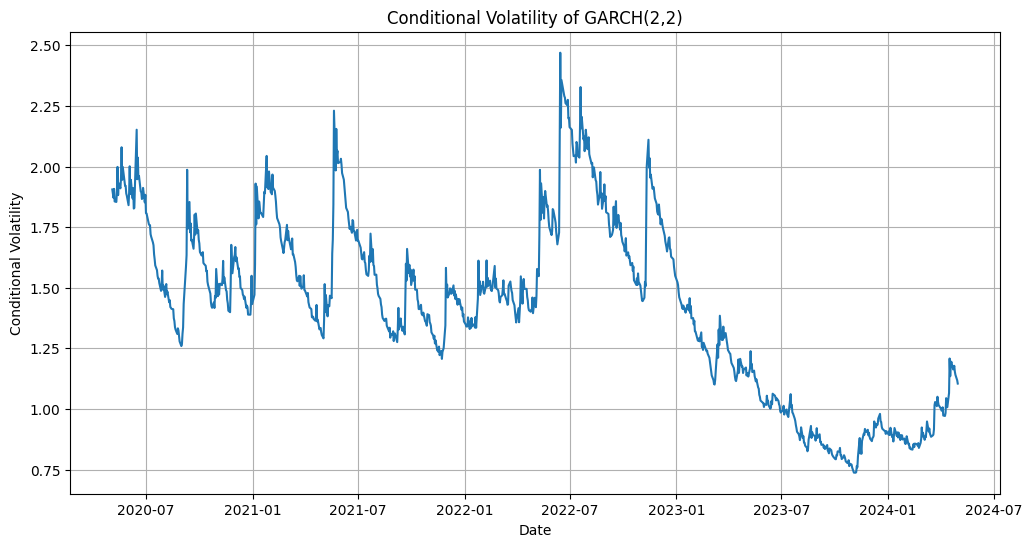

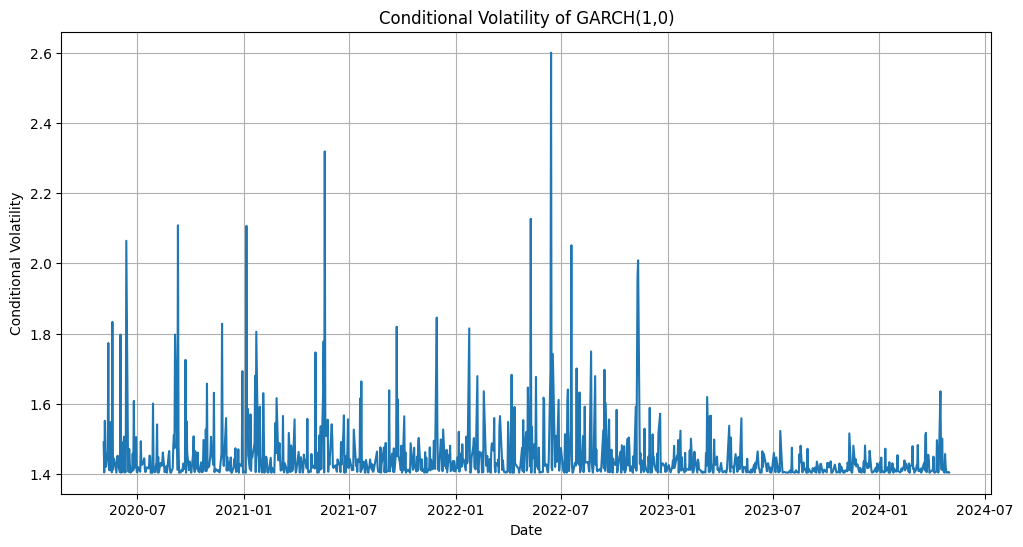

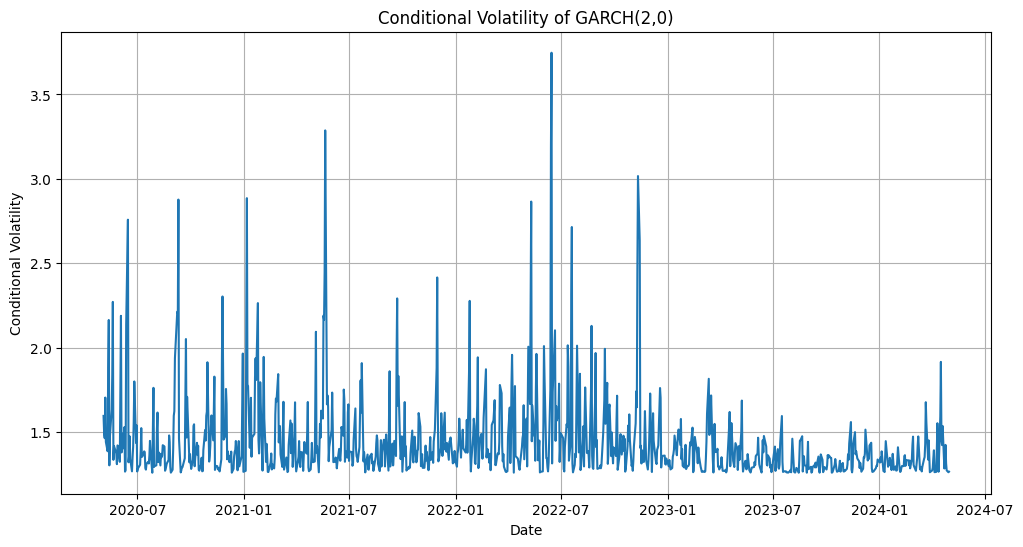

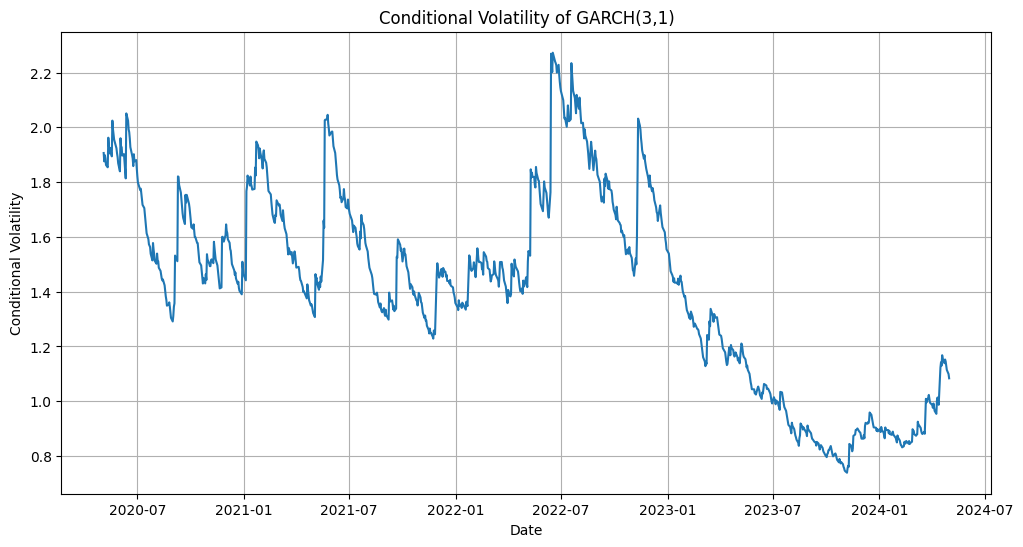

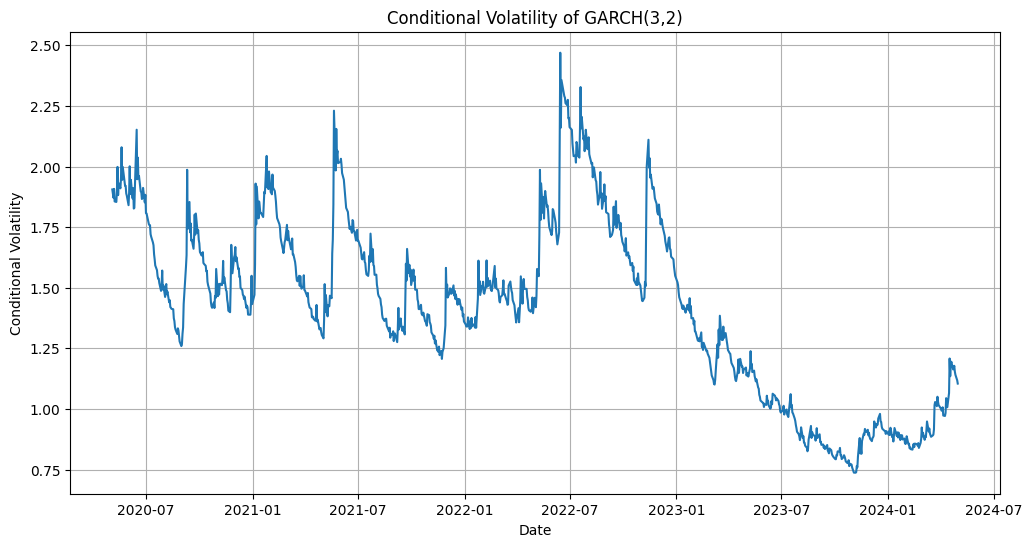

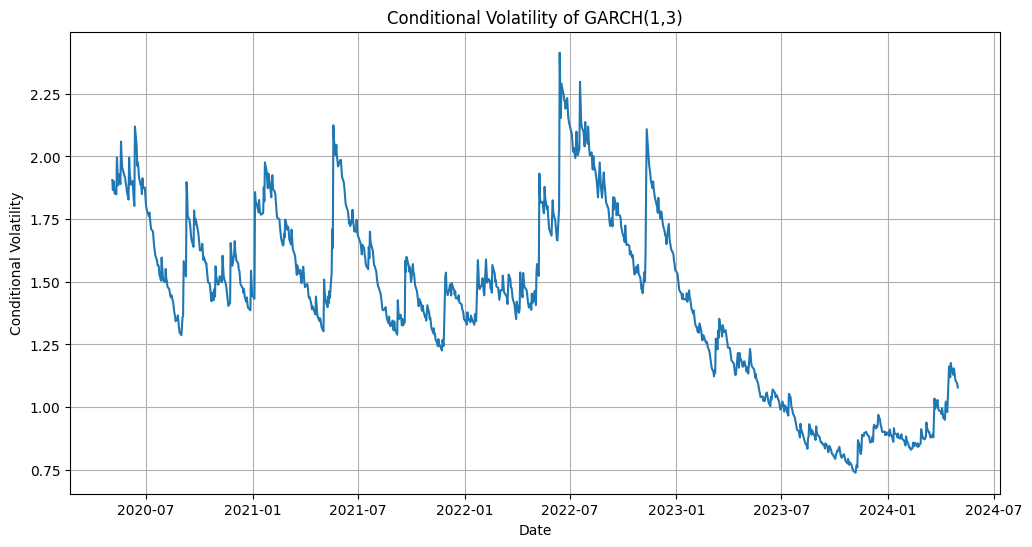

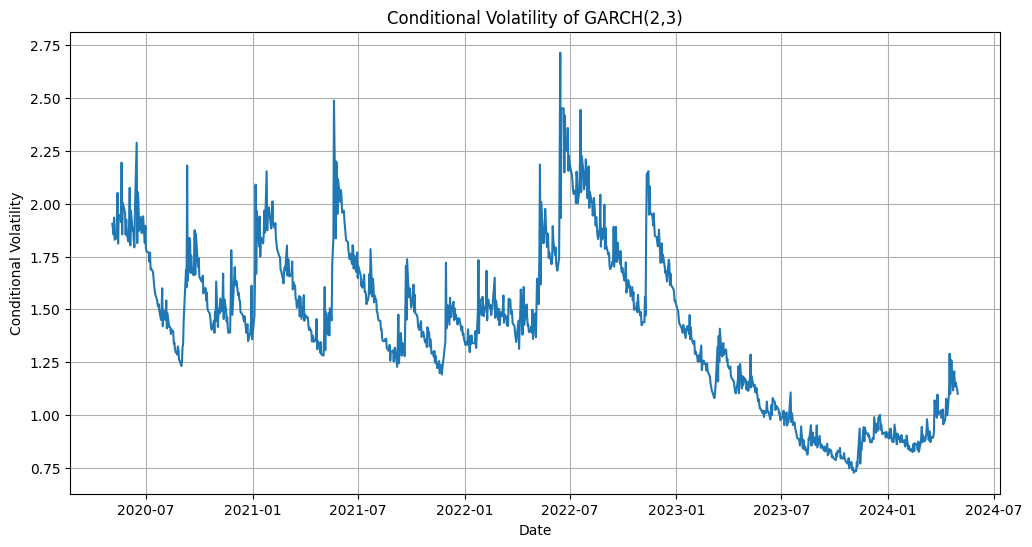

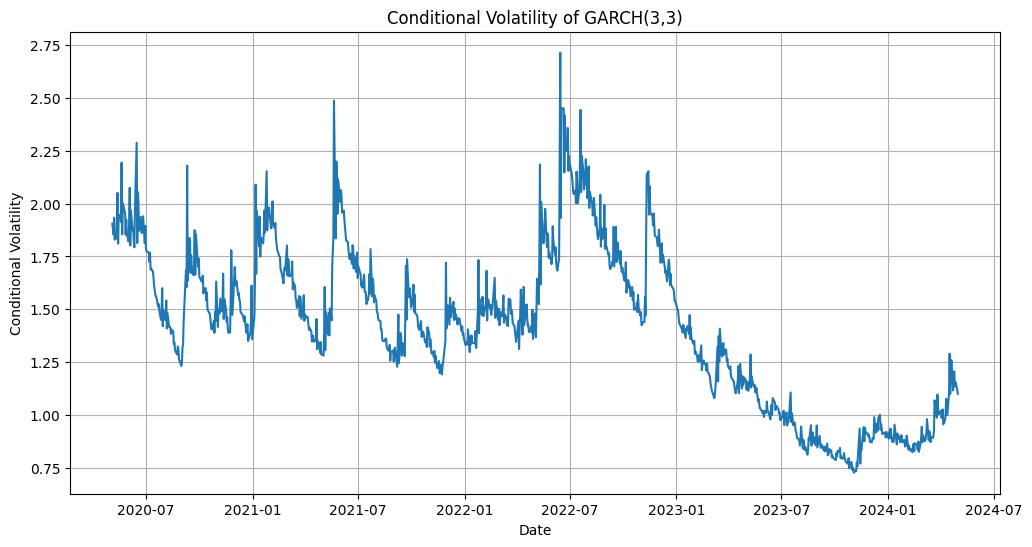

In [95]:
for name, model in models.items():
    plt.figure(figsize=(12, 6))
    plt.plot(model.conditional_volatility)
    plt.title(f'Conditional Volatility of {name}')
    plt.xlabel('Date')
    plt.ylabel('Conditional Volatility')
    plt.grid()
    plt.show()

In [97]:
model_egarch111 = arch_model(data_train['portfolio'] * 100, vol='EGARCH', p=1, o=1, q=1)
results_egarch111 = model_egarch111.fit(disp='off')
print(results_egarch111.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -1748.53
Distribution:                  Normal   AIC:                           3507.05
Method:            Maximum Likelihood   BIC:                           3531.61
                                        No. Observations:                 1005
Date:                Fri, May 30 2025   Df Residuals:                     1004
Time:                        12:14:11   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1062  4.013e-02      2.647  8.133e-03 [2.755e-0

In [98]:
model_egarch121 = arch_model(data_train['portfolio'] * 100, vol='EGARCH', p=1, o=2, q=1)
results_egarch121 = model_egarch121.fit(disp='off')
print(results_egarch121.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -1740.58
Distribution:                  Normal   AIC:                           3493.16
Method:            Maximum Likelihood   BIC:                           3522.63
                                        No. Observations:                 1005
Date:                Fri, May 30 2025   Df Residuals:                     1004
Time:                        12:14:11   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1111  3.929e-02      2.829  4.675e-03 [3.413e-0

In [99]:
lr_stat  = 2*(results_egarch121.loglikelihood - results_egarch111.loglikelihood)
df       = results_egarch121.num_params - results_egarch111.num_params
p_value  = 1 - stats.chi2.cdf(lr_stat, df)
print(f"LR stat={lr_stat:.2f}, df={df}, p‐value={p_value:.3f}")

LR stat=15.90, df=1, p‐value=0.000


In [117]:
lr_stat  = 2*(results_egarch121.loglikelihood - results_garch11.loglikelihood)
df       = results_egarch121.num_params - results_garch11.num_params
p_value  = 1 - stats.chi2.cdf(lr_stat, df)
print(f"LR stat={lr_stat:.2f}, df={df}, p‐value={p_value:.3f}")

LR stat=16.24, df=2, p‐value=0.000


In [100]:
good_models = {
    'GARCH(1,1)': results_garch11,
    'EGARCH(1,2,1)': results_egarch121
}

In [101]:
from statsmodels.stats.diagnostic import breaks_cusumolsresid, breaks_hansen
def garch_model_diagnostics(models, gof_bins=20):
    """
    Run CUSUM & Hansen stability tests, Engle–Ng sign/size‐bias tests,
    and an Adjusted‐Pearson GOF on a dict of fitted ARCH/GARCH results.

    Parameters
    ----------
    models : dict
        { model_name : fitted_arch_results_object, … }
    gof_bins : int
        # of bins for the GOF χ² test.

    Returns
    -------
    pd.DataFrame
        Index = model names; columns are test stats and p-values.
    """
    rows = []
    for name, res in models.items():
        # 1) Standardized residuals
        std = res.std_resid.dropna()
        n   = len(std)

        # 2) CUSUM & Hansen (parameter‐stability)
        sup_b, p_cusum, crit_cusum = breaks_cusumolsresid(std, ddof=res.params.shape[0])
        # Hansen’s test needs an OLSResults on a constant
        ols_res = sm.OLS(std, np.ones((n, 1))).fit()
        stat_hansen, crit_hansen = breaks_hansen(ols_res)

        # 3) Engle–Ng sign and size bias
        y   = std**2
        d   = (std.shift(1) < 0).astype(int).fillna(0)
        neg = d * std.shift(1)
        pos = (1 - d) * std.shift(1)
        X = pd.DataFrame({
            'const': 1,
            'sign_bias': d,
            'neg_size': neg,
            'pos_size': pos
        }).fillna(0)
        ng = sm.OLS(y, X).fit()
        f_stat = ng.fvalue
        p_ng   = ng.f_pvalue

        # 4) Adjusted‐Pearson GOF on the PIT of std_resid
        dist_name = res.model.distribution.name.lower()
        if 't' in dist_name:
            dfree = res.params.get('nu', None)
            u = stats.t.cdf(std, df=dfree) if dfree is not None else stats.t.cdf(std, *res.model.distribution.parameters)
        else:
            u = stats.norm.cdf(std)

        counts, _ = np.histogram(u, bins=gof_bins)
        expected  = np.ones_like(counts) * n / len(counts)
        chi2, p_gof = stats.chisquare(counts, f_exp=expected)

        rows.append({
            'Model'         : name,
            'CUSUM_stat'    : sup_b,
            'CUSUM_p'       : p_cusum,
            'Hansen_stat'   : stat_hansen,
            'Hansen_crit'   : crit_hansen,
            # no p-value from Hansen; compare stat→crit if desired
            'EngleNg_F'     : f_stat,
            'EngleNg_p'     : p_ng,
            'GOF_chi2'      : chi2,
            'GOF_p'         : p_gof
        })

    df = pd.DataFrame(rows).set_index('Model')
    return df

garch_model_diagnostics(good_models)

,CUSUM_stat,CUSUM_p,Hansen_stat,Hansen_crit,EngleNg_F,EngleNg_p,GOF_chi2,GOF_p
Model,,,,,,,,
"GARCH(1,1)",1.460120,0.028134,0.663893,"[[2, 1.01], [6, 1.9], [15, 3.75], [19, 4.52]]",3.430798,0.016595,26.701493,0.111801
"EGARCH(1,2,1)",1.442909,0.031091,0.703022,"[[2, 1.01], [6, 1.9], [15, 3.75], [19, 4.52]]",0.810941,0.487875,31.636816,0.034326


In [102]:
def news_impact_curve(shocks, omega, alpha, beta, gamma=0): 
    variances = omega + alpha * shocks**2 + beta * (omega / (1 - alpha - beta)) + gamma * shocks  # Steady-state variance 
    return variances 

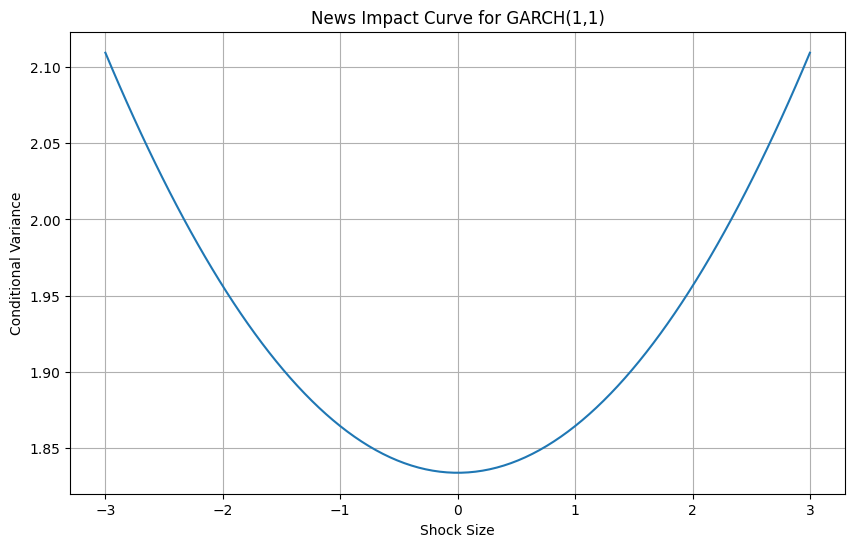

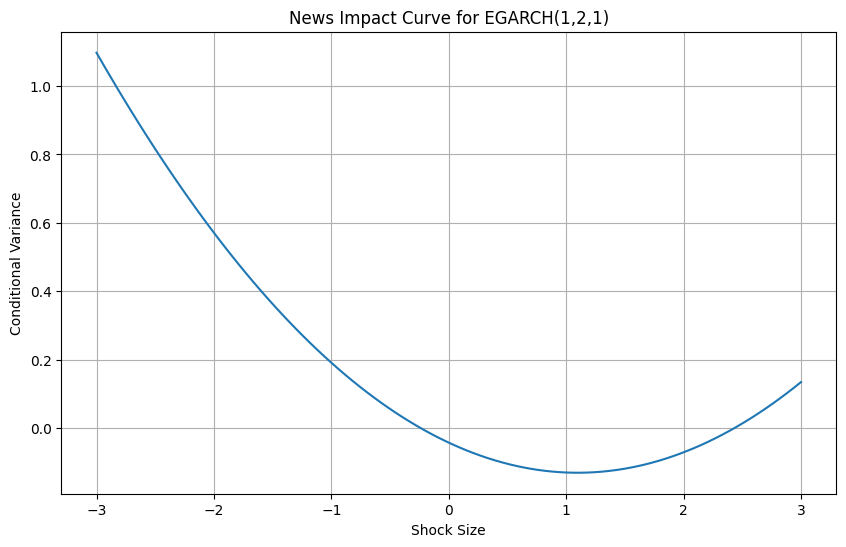

In [103]:
for name, model in good_models.items():
    variances = news_impact_curve(np.linspace(-3, 3, 100),
                                        model.params['omega'],
                                        model.params['alpha[1]'],
                                        model.params['beta[1]'],
                                        model.params.get('gamma[1]', 0))  # gamma is optional, default to 0 if not present
    plt.figure(figsize=(10, 6))
    plt.plot(np.linspace(-3, 3, 100), variances)
    plt.title(f'News Impact Curve for {name}')
    plt.xlabel('Shock Size')
    plt.ylabel('Conditional Variance')
    plt.grid()
    plt.show()  

In [104]:
data_train_portfolio = data_train['portfolio'].copy()
data_train_portfolio_mean = data_train_portfolio.mean()
data_train_portfolio_std = data_train_portfolio.std()
data_train['portfolio_std'] = (data_train_portfolio - data_train_portfolio_mean) / data_train_portfolio_std

In [105]:
q01_empirical_portfolio = data_train['portfolio_std'].quantile(0.01)
conditional_volatility_garch11 = results_garch11.conditional_volatility
conditional_volatility_egarch121 = results_egarch121.conditional_volatility

data_train.loc[conditional_volatility_garch11.index, 'VaR_GARCH(1,1)'] = q01_empirical_portfolio * conditional_volatility_garch11
data_train.loc[conditional_volatility_egarch121.index, 'VaR_EGARCH(1,2,1)'] = q01_empirical_portfolio * conditional_volatility_egarch121

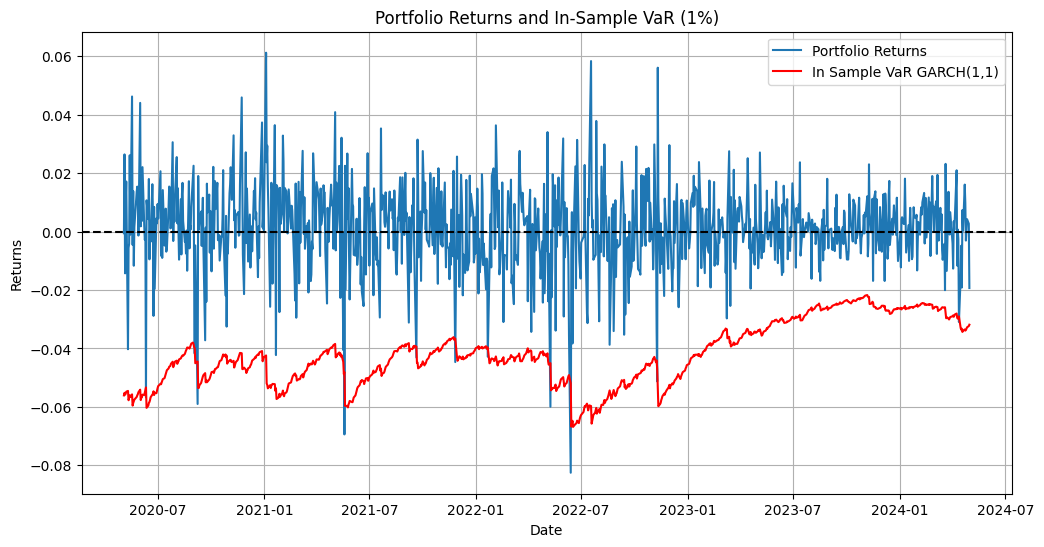

In [106]:
# Plot returns and VaR for GARCH(1,1)
plt.figure(figsize=(12, 6))
plt.plot(data_train.index, data_train['portfolio'], label='Portfolio Returns')
plt.plot(data_train.index, data_train['VaR_GARCH(1,1)'] / 100, label='In Sample VaR GARCH(1,1)', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Portfolio Returns and In-Sample VaR (1%)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.show()

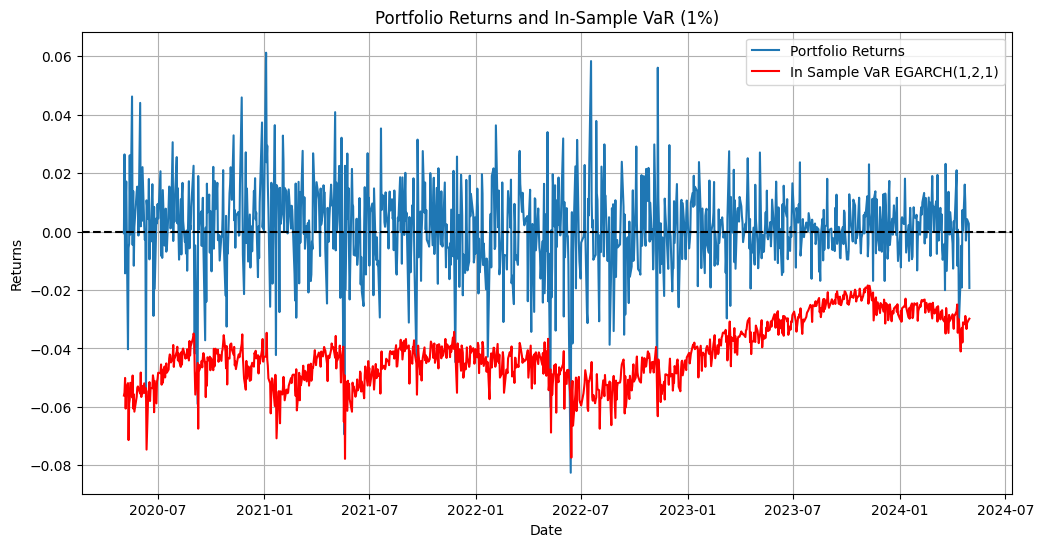

In [107]:
# Plot returns and VaR for EGARCH(1,2,1)
plt.figure(figsize=(12, 6))
plt.plot(data_train.index, data_train['portfolio'], label='Portfolio Returns')
plt.plot(data_train.index, data_train['VaR_EGARCH(1,2,1)'] / 100, label='In Sample VaR EGARCH(1,2,1)', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Portfolio Returns and In-Sample VaR (1%)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.show()

In [108]:
# Number and share of observations below VaR
def calculate_var_metrics(dataframe, var_column):
    below_var = dataframe[dataframe['portfolio'] < (dataframe[var_column] / 100)]
    num_below_var = len(below_var)
    share_below_var = num_below_var / len(dataframe) * 100
    return num_below_var, share_below_var

In [109]:
below_var_garch = calculate_var_metrics(data_train, 'VaR_GARCH(1,1)')
below_var_egarch = calculate_var_metrics(data_train, 'VaR_EGARCH(1,2,1)')

print(f"GARCH(1,1) - Number of observations below VaR: {below_var_garch[0]}, Share: {below_var_garch[1]:.2f}%")
print(f"EGARCH(1,2,1) - Number of observations below VaR: {below_var_egarch[0]}, Share: {below_var_egarch[1]:.2f}%")

GARCH(1,1) - Number of observations below VaR: 11, Share: 1.09%
EGARCH(1,2,1) - Number of observations below VaR: 8, Share: 0.80%


In [110]:
data_test_portfolio = data_test['portfolio'].copy()
data_test_portfolio_mean = data_test_portfolio.mean()
data_test_portfolio_std = data_test_portfolio.std()
data_test['portfolio_std'] = (data_test_portfolio - data_test_portfolio_mean) / data_test_portfolio_std

In [111]:
VaR_garch11 = np.zeros(len(data_test))
VaR_egarch121 = np.zeros(len(data_test))

for i in range(len(data_test)):
    current_forecast_target_date = data_test.index[i]
    tmp_estimation_data = data[data.index < current_forecast_target_date].copy()
    tmp_estimation_data['portfolio_std'] = (tmp_estimation_data['portfolio'] - tmp_estimation_data['portfolio'].mean()) / tmp_estimation_data['portfolio'].std()
    qo1_rolling_empirical_portfolio = tmp_estimation_data['portfolio_std'].quantile(0.01)

    model_rolling_garch11 = arch_model(tmp_estimation_data['portfolio'] * 100, vol='Garch', p=1, q=1)
    results_rolling_garch11 = model_rolling_garch11.fit(disp='off')
    model_rolling_egarch121 = arch_model(tmp_estimation_data['portfolio'] * 100, vol='EGARCH', p=1, o=2, q=1)
    results_rolling_egarch121 = model_rolling_egarch121.fit(disp='off')

    forecast_rolling_garch11 = results_rolling_garch11.forecast(horizon=1, reindex=False)
    forecast_rolling_egarch121 = results_rolling_egarch121.forecast(horizon=1, reindex=False)

    sigma_forecast_rolling_garch11 = forecast_rolling_garch11.variance.iloc[-1, 0] ** 0.5
    sigma_forecast_rolling_egarch121 = forecast_rolling_egarch121.variance.iloc[-1, 0] ** 0.5

    VaR_garch11[i] = qo1_rolling_empirical_portfolio * sigma_forecast_rolling_garch11
    VaR_egarch121[i] = qo1_rolling_empirical_portfolio * sigma_forecast_rolling_egarch121



In [112]:
data_test['VaR_GARCH(1,1)'] = VaR_garch11
data_test['VaR_EGARCH(1,2,1)'] = VaR_egarch121

In [113]:
data_test

,JPMorgan,BrentOil,Ethereum,NASDAQ,PLNUSD,portfolio,portfolio_std,"VaR_GARCH(1,1)","VaR_EGARCH(1,2,1)"
Date,,,,,,,,,
2024-05-01,0.000626,-0.051617,-0.014210,-0.007028,-0.008510,-0.016148,-1.162762,-3.310534,-3.719407
2024-05-02,-0.001043,0.002753,0.006171,0.012794,0.006472,0.005429,0.422123,-3.386313,-3.589746
2024-05-03,-0.006018,-0.008522,0.037883,0.019715,-0.000014,0.008609,0.655654,-3.337654,-3.058741
2024-05-06,0.007791,0.004450,-0.013238,0.011270,0.005040,0.003063,0.248281,-3.308657,-2.966298
2024-05-07,-0.001303,-0.002042,-0.018504,-0.000117,0.003793,-0.003635,-0.243652,-3.256445,-3.033920
...,...,...,...,...,...,...,...,...,...
2025-04-24,0.015489,0.006482,-0.014736,0.027497,-0.002817,0.006383,0.492180,-6.414046,-5.623377
2025-04-25,-0.004465,0.004797,0.009449,0.011290,0.007651,0.005744,0.445259,-6.260269,-5.473535
2025-04-28,-0.001356,-0.015219,0.006815,-0.000271,-0.002023,-0.002411,-0.153764,-6.115125,-5.343685


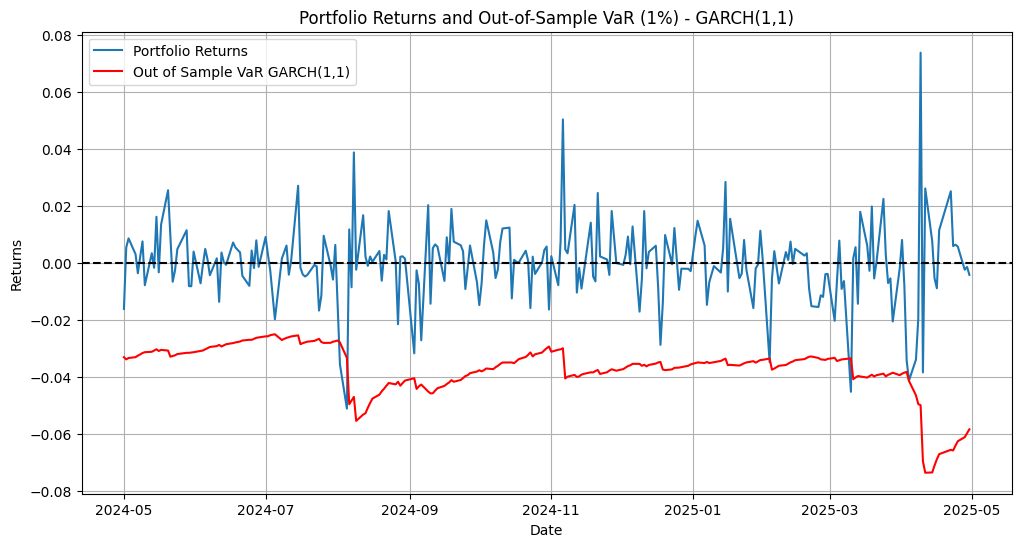

In [114]:
# Plot returns and VaR for GARCH(1,1) in test set
plt.figure(figsize=(12, 6))
plt.plot(data_test.index, data_test['portfolio'], label='Portfolio Returns')
plt.plot(data_test.index, data_test['VaR_GARCH(1,1)'] / 100, label='Out of Sample VaR GARCH(1,1)', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Portfolio Returns and Out-of-Sample VaR (1%) - GARCH(1,1)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.show()

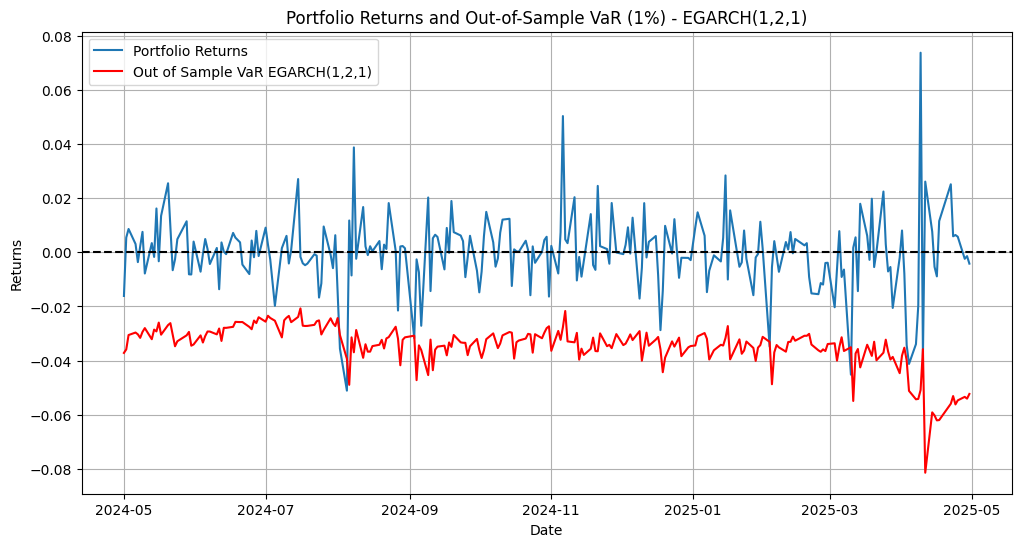

In [115]:
# Plot returns and VaR for EGARCH(1,2,1) in test set
plt.figure(figsize=(12, 6))
plt.plot(data_test.index, data_test['portfolio'], label='Portfolio Returns')
plt.plot(data_test.index, data_test['VaR_EGARCH(1,2,1)'] / 100, label='Out of Sample VaR EGARCH(1,2,1)', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Portfolio Returns and Out-of-Sample VaR (1%) - EGARCH(1,2,1)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.show()

In [116]:
# Number and share of observations below VaR in test set
below_var_test_garch = calculate_var_metrics(data_test, 'VaR_GARCH(1,1)')
below_var_test_egarch = calculate_var_metrics(data_test, 'VaR_EGARCH(1,2,1)')
print(f"GARCH(1,1) - Number of observations below VaR in test set: {below_var_test_garch[0]} out of {len(data_test)}, Share: {below_var_test_garch[1]:.2f}%")
print(f"EGARCH(1,2,1) - Number of observations below VaR in test set: {below_var_test_egarch[0]} out of {len(data_test)}, Share: {below_var_test_egarch[1]:.2f}%")

GARCH(1,1) - Number of observations below VaR in test set: 4 out of 249, Share: 1.61%
EGARCH(1,2,1) - Number of observations below VaR in test set: 6 out of 249, Share: 2.41%
